In [100]:
import numpy as np
from numpy import sqrt
from utils.TlF import *
import matplotlib.pyplot as plt
from utils.hamiltonianoperators import *
from utils.effective_hamiltonian import *

In [101]:
graph_dir = 'graphs/'

In [102]:
Jmax = 6
QN = np.array([BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J in range(Jmax+1)
      for mJ in range(-J,J+1)
      for m1 in np.arange(-I_Tl,I_Tl+1)
      for m2 in np.arange(-I_F,I_F+1)])

In [103]:
%%time
def HMatElems(H, QN):
    result = np.empty((len(QN),len(QN)), dtype=complex)
    for i,a in enumerate(QN):
        for j,b in enumerate(QN):
            result[i,j] = (1*a)@H(b)
    return result

Hff_m = HMatElems(Hff, QN)
HSx_m = HMatElems(HSx, QN)
HSy_m = HMatElems(HSy, QN)
HSz_m = HMatElems(HSz, QN)
HZx_m = HMatElems(HZx, QN)
HZy_m = HMatElems(HZy, QN)
HZz_m = HMatElems(HZz, QN)

Wall time: 57.5 s


### Effective Hamiltonian for $B_z = 20G$ as a funtion of $E$

In [104]:
%%time
H0 = Hff_m + 20*HZz_m
variables = ['x', 'y', 'z']
Hpert = [HSx_m, HSy_m, HSz_m]
U, Heff = generate_effective_hamiltonian(H0, variables, Hpert, J=2, order=3, Jmax=6)

Wall time: 316 ms


In [105]:
Jmax = 6
hamiltonian_dimension = 4*(Jmax+1)**2
indexing = np.arange(0,hamiltonian_dimension**2,1,dtype = int).reshape(hamiltonian_dimension,hamiltonian_dimension)

In [106]:
idx_min, idx_max = index_range(2)
P0 = np.eye(4*(Jmax+1)**2, dtype = int)
mask = np.zeros(P0.shape, dtype = bool)
mask[idx_min:idx_max, idx_min:idx_max] = True
P0[~mask] = 0
Q0 = np.eye(4*(Jmax+1)**2,dtype = int) - P0
Q0a = generate_Q0a(H0, P0, 2, 6)

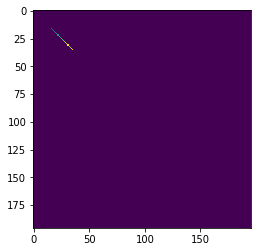

In [107]:
tmp = indexing.copy()
tmp[HSz_m == 0] = 0
plt.imshow(np.abs(P0@tmp@Q0@tmp@P0))

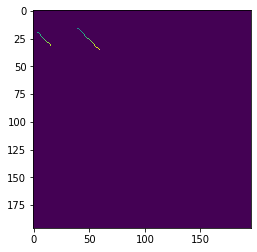

In [108]:
plt.imshow(P0@tmp)

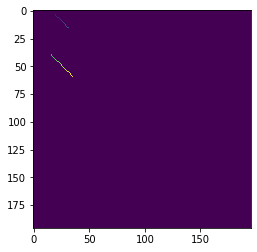

In [109]:
plt.imshow(Q0@tmp@P0)

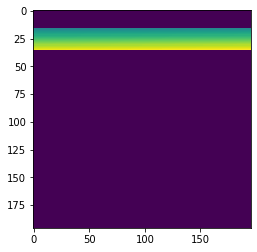

In [110]:
plt.imshow(P0@indexing)

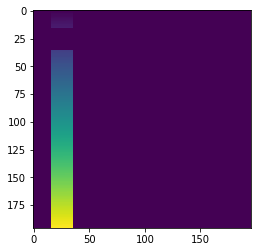

In [111]:
plt.imshow(Q0@indexing@P0)

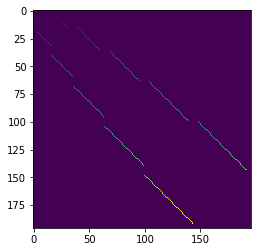

In [112]:
plt.imshow(tmp)

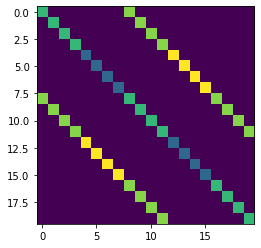

In [113]:
plt.imshow(np.abs(Heff[1]['xx']))

In [114]:
import networkx as nx

In [115]:
def index_to_J(idx,Jmax=6):
    idx = int(idx)
    idx_to_J = lambda idx: int(np.sqrt(idx/4))
    idx_max = int(4*(Jmax+1)**2)
    id1, id2 = idx//idx_max, idx%idx_max
    return id1, id2, idx_to_J(id1), idx_to_J(id2)

In [248]:
import networkx as nx
from tqdm import tqdm
from utils.effective_hamiltonian import index_range


def index_to_J(idx,Jmax=6):
    idx = int(idx)
    idx_to_J = lambda idx: int(np.sqrt(idx/4))
    idx_max = int(4*(Jmax+1)**2)
    id1, id2 = idx//idx_max, idx%idx_max
    return id1, id2, idx_to_J(id1), idx_to_J(id2)

def matrix_multiplication_nodes(mats1, mats2, coupling, graph, J, QN):
    mat1_ind, mat1 = mats1
    mat2_ind, mat2 = mats2
    
    idx_min, idx_max = index_range(J)
    for i in range(idx_min, idx_max):
        for j in range(idx_min, idx_max):
            for k in range(len(mat1)):
                v1 = mat1_ind[i,k]
                v2 = mat2_ind[k,j]
                if (v1 != 0) and (v2 != 0):
                    id1_1,id2_1,J1_1,J2_1 = index_to_J(v1)
                    id1_2,id2_2,J1_2,J2_2 = index_to_J(v2)
                    for k in [id1_1, id1_2, id2_2]:
                        qn = QN[k]
                        graph.add_node(k, **dict([('J',qn.J),('mJ',qn.mJ),('m1',qn.m1),('m2',qn.m2)]))
                    graph.add_edge(id2_1,id1_1, **dict([('coupling_strength',mat1[id1_1,id2_1]), 
                                                        ('order',2), ('state',i), ('coupling', coupling)]))
                    graph.add_edge(id2_2,id1_2, **dict([('coupling_strength',mat2[id1_2,id2_2]), 
                                                        ('order',2), ('state',i), ('coupling', coupling)]))


def generate_graph(Hpertubations, order = 2, Jmax = 6):
    graph = nx.MultiDiGraph()
    
    hamiltonian_dimension = 4*(Jmax+1)**2
    indexing = np.arange(0,hamiltonian_dimension**2,1,dtype = int).reshape(hamiltonian_dimension,hamiltonian_dimension)
    
    for (pert1, pert2) in tqdm(itertools.product(*[list(Hpertubations.keys())]*2), smoothing = 0, 
                               total = len(Hpertubations)**2):
        index_mat1 = indexing.copy()
        index_mat2 = indexing.copy()
        mat1 = P0@Hpertubations[pert1]
        mat2 = Q0a@Hpertubations[pert2]@P0
        index_mat1[mat1 == 0] = 0
        index_mat2[mat2 == 0] = 0
        coupling = pert1+','+pert2
        matrix_multiplication_nodes((index_mat1, mat1), (index_mat2, mat2), coupling, graph, 2, QN)
    return graph

In [365]:
Hpertubations = {'HSx': HSx_m, 'HSy': HSy_m , 'HSz': HSz_m}
# Hpertubations = {'HSx': HSx_m, 'HSz': HSz_m}
# Hpertubations = {'HSx': HSx_m}
Graph = generate_graph(Hpertubations)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.81it/s]


In [366]:
def append_if_not_in_list(lst, to_append):
    if to_append in lst:
        return
    else:
        lst.append(to_append)
    
def append_if_not_in_list_iterarable(lst, to_append):
    for entry in to_append:
        if entry not in lst:
            lst.append(entry)
    return lst

def get_connected_nodes(graph, J=2):
    idx_min, idx_max = index_range(J)
    
    couplings = set(nx.get_edge_attributes(Graph, 'coupling').values())
    connected = {coupling : [] for coupling in couplings}
    for coupling in couplings:
        for node in range(idx_min,idx_max):
            connected_tmp = [node]
            for cn in connected_tmp:
                connected_tmp = append_if_not_in_list_iterarable(connected_tmp, 
                set([s for s,t,data in Graph.in_edges(cn, data = True) if data['coupling'] == coupling]))
            connected_tmp.sort()
            check_if_done(connected[coupling], connected_tmp)
    return connected

In [367]:
connected = get_connected_nodes(Graph)

In [368]:
def get_connected_graphs(graph, connected, J=2):
    idx_min, idx_max = index_range(J)
        
    connected_graphs = {}

    for cn in connected:
        g = nx.MultiDiGraph()
        for node in cn:
            g.add_node(node, **graph.nodes[node])

        for node in g.nodes:
            gi = g.copy()
            if idx_min <= node <  idx_max:
                for n1,n2,edge_dict in graph.edges(cn, data = True):
                    if edge_dict['state'] == node:
                        gi.add_edge(n1,n2,**edge_dict)
                gi.remove_nodes_from(list(nx.isolates(gi)))
                connected_graphs[node] = gi.copy()
    return connected_graphs

In [369]:
def get_connected_graphs_coupling(graph, connected, coupling, J=2):
    idx_min, idx_max = index_range(J)
        
    connected_graphs = {}


    for cn in connected:
        g = nx.MultiDiGraph()
        for node in cn:
            g.add_node(node, **graph.nodes[node])

        for node in g.nodes:
            gi = g.copy()
            if idx_min <= node <  idx_max:
                for n1,n2,edge_dict in graph.edges(cn, data = True):
                    if (edge_dict['state'] == node) & (edge_dict['coupling'] == coupling):
                        gi.add_edge(n1,n2,**edge_dict)
                gi.remove_nodes_from(list(nx.isolates(gi)))
                connected_graphs[node] = gi.copy()
    return connected_graphs

def get_connected_graphs(graph, connected):
    couplings = connected.keys()
    connected_graphs = {coupling: {} for coupling in couplings}
    for coupling in couplings:
        connected_graphs[coupling] = get_connected_graphs_coupling(Graph, connected[coupling], coupling)
    return connected_graphs

In [370]:
connected_graphs = get_connected_graphs(Graph, connected)

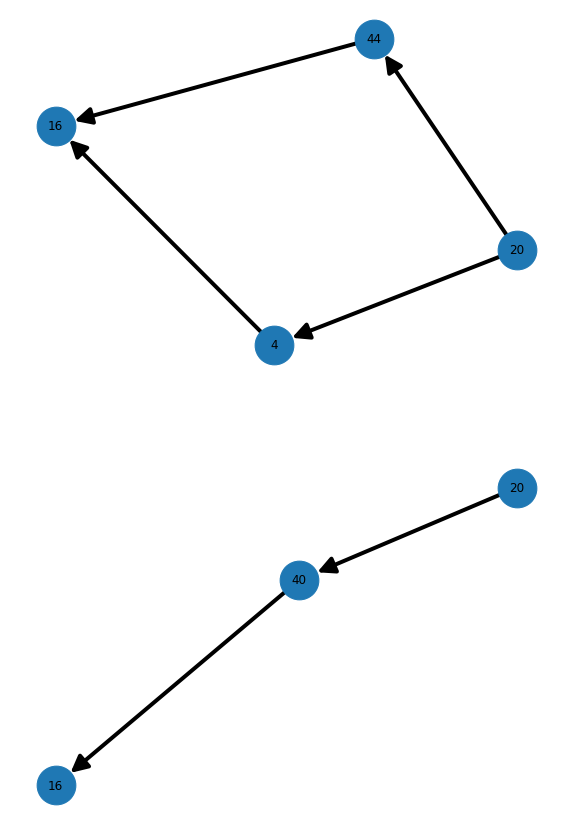

In [374]:
idx = 16
fig, (ax0,ax1) = plt.subplots(nrows = 2, figsize = (10,15))
nx.drawing.nx_pylab.draw(connected_graphs['HSy,HSz'][idx], ax = ax0, 
                         node_size = 1500, width = 4, with_labels=True, arrowsize = 35)
nx.drawing.nx_pylab.draw(connected_graphs['HSz,HSy'][idx], ax = ax1, 
                         node_size = 1500, width = 4, with_labels=True, arrowsize = 35)

Order of the Hamiltonian operators results in different intermediate states coupling the same initial and final states together. E.g. `P0@HSx_m@Q0a@HSz_m@P0` couples different states than `P0@HSz_m@Q0a@HSx_m@P0`.

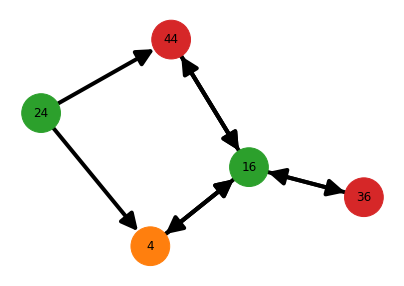

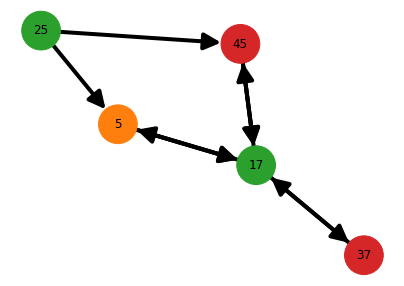

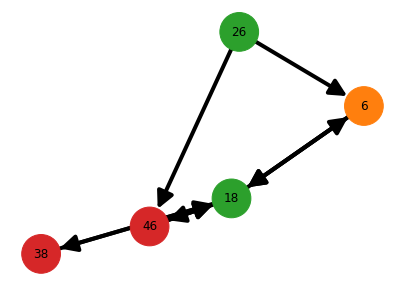

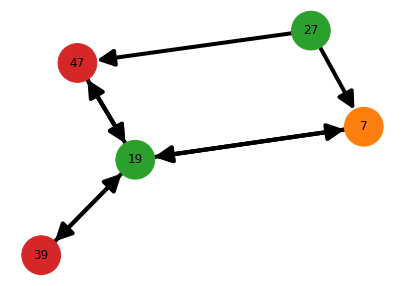

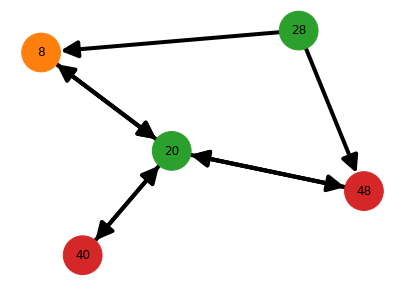

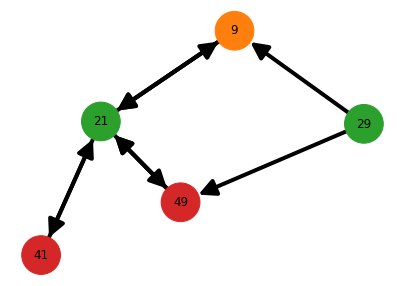

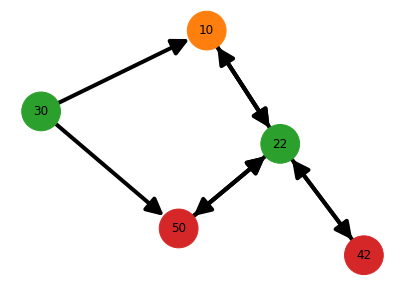

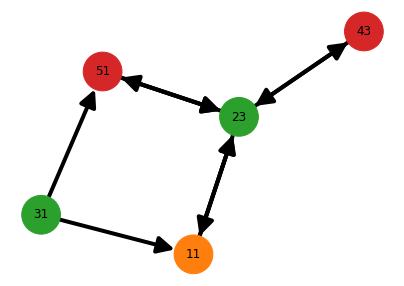

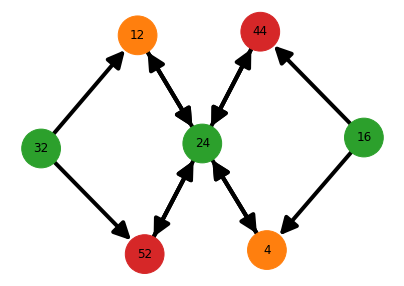

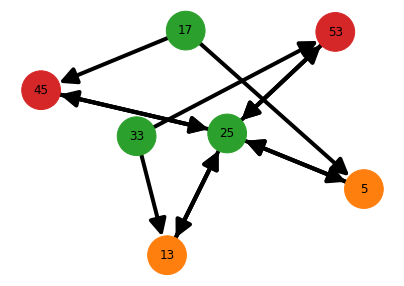

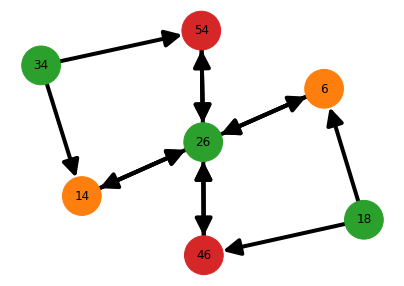

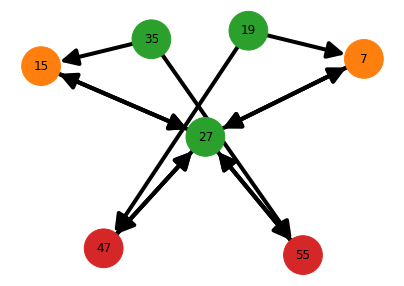

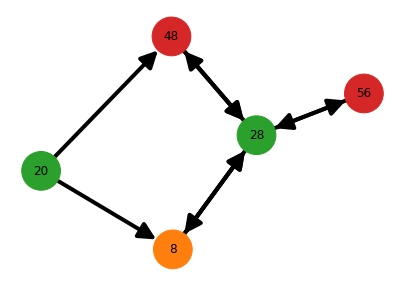

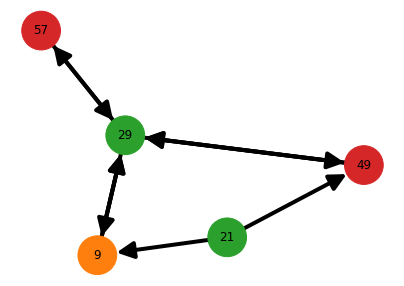

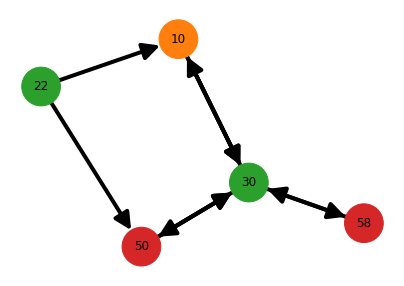

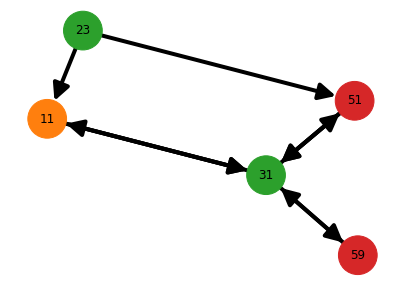

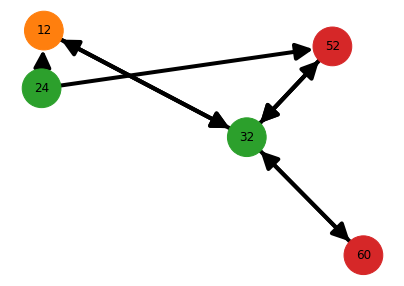

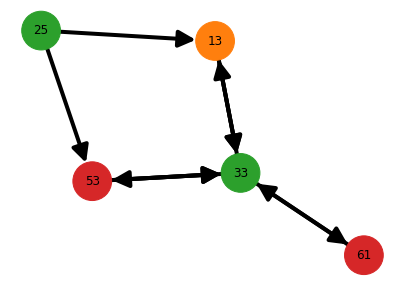

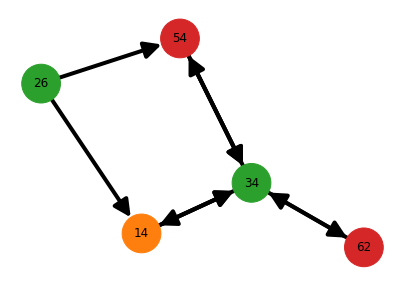

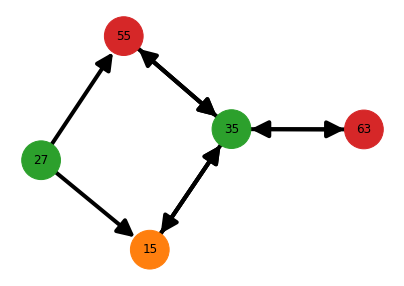

In [375]:
coupling = 'HSx,HSx'
for cn in sorted(connected_graphs[coupling].keys()):
    cn = connected_graphs[coupling][cn]
    color_mapping = {0: 'C0', 1:'C1', 2:'C2', 3:'C3'}
    node_colors = list(nx.get_node_attributes(cn,'J').values())
    node_colors = [color_mapping[n] for n in node_colors]
    
#     edges, edge_colors = zip(*nx.get_edge_attributes(cn, 'coupling').items())
#     edge_colors = normalize_list([np.abs(c) for c in edge_colors])
#     edge_colors = np.array(edge_colors).astype(float)

    fig,ax = plt.subplots(figsize = (7,5))
    
    nx.draw(cn, node_size = 1500, width = 4, with_labels=True, node_color = node_colors, arrowsize = 35)
#     sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = min(edge_colors), vmax=max(edge_colors)))
#     nx.draw(cn, node_size = 1500, width = 4, with_labels=True, node_color = node_colors, arrowsize = 35,
#             edgelist = edges, edge_color = edge_colors)
#     fig.colorbar(sm)

In [376]:
def _find_paths_digraph(G,u,n):
    """
    G : graph
    u : target
    n : length
    """
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.predecessors(u) for path in _find_paths_digraph(G,neighbor,n-1)]
    return paths

def find_paths_digraph(G,u,n):
    """
    G : graph
    u : target
    n : length
    """
    paths = _find_paths_digraph(G,u,n)
    return [p[::-1] for p in paths]

def get_couplings_paths(G,paths,coupling):
    edge_couplings = []
    for path in paths:
        coupling = 1
        edges = [(n1,n2) for n1, n2 in zip(path[:-1],path[1:])]
        for edge in edges:
            edge_data = G.get_edge_data(*edge)[0]
            coupling *= edge_data['coupling_strength']
        edge_couplings.append({'nodes': path, 'edges': edges,'coupling': coupling})
    return edge_couplings


In [381]:
idx = 23
coupling = 'HSz,HSy'
_ = connected_graphs[coupling][idx]
print(get_couplings_paths(_, find_paths_digraph(_, idx, 2), coupling))

[{'nodes': [19, 7, 23], 'edges': [(19, 7), (7, 23)], 'coupling': (-0-33.8615528318068j)}, {'nodes': [27, 7, 23], 'edges': [(27, 7), (7, 23)], 'coupling': (-0-13.823921056036905j)}, {'nodes': [19, 47, 23], 'edges': [(19, 47), (47, 23)], 'coupling': (-0-6.449819587010813j)}, {'nodes': [27, 47, 23], 'edges': [(27, 47), (47, 23)], 'coupling': (-0-15.798766921185022j)}]


In [382]:
def normalize_list(l):
    mi, ma = min(l), max(l)
    return [(val - mi)/(ma-mi) for val in l]

In [500]:
import matplotlib.colors as colors
from collections import Counter

def set_node_color(n):
    color_map = dict([(0,'C0'),(1,'C1'), (2,'C2'), (3,'C3'), (4,'C4'), (5,'C5'),(6,'C6')])
    color_map = dict([(key, colors.to_hex(val)) for key, val in color_map.items()])
    J = int(n.attr['J'])
    n.attr['fillcolor'] = color_map[J]
    return n

def set_node_label(n):
    n.attr['label'] = f"{int(n.attr['mJ']):+d}, {float(n.attr['m1']):+.1f}, {float(n.attr['m2']):+.1f}"
    
def set_edge_couplings(edges, width = 4, scale = 'log'):
    couplings = [np.complex(e.attr['coupling']) for e in edges]
    couplings = np.abs(couplings)
    mi, ma = couplings.min(), couplings.max()
    norm = width*(couplings-mi)/(ma-mi)
    for wi, edge in zip(norm, edges):
        edge.attr['penwidth'] = wi

def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b
        
def set_path_couplings(paths, width = 4, min_width = 1, scale = 'linear'):
    edges = []
    couplings = []
    for path in paths:
        edges.extend(list(path[0]))
        couplings.extend([path[1]]*len(path[0]))
    counter = Counter(edges)
    norm = rescale_linear(np.abs(couplings), min_width, width)
    edges_key = []
    for edge in edges:
        counter[edge] -= 1
        cnt = counter[edge]
        edges_key.append((*edge, cnt))
    return edges_key, norm

def _get_path_couplings_direction(paths):
    
    edges = []
    directions = []
    couplings = []
    labels = []
    
    counter = {}
    
    idx = 1
    for path in paths:
        nodes    = path['nodes']
        edge    = path['edges']
        coupling = path['coupling']
        
        if edge[0][0] == edge[-1][-1]:
            if not isinstance(counter.get(edge[0], None), type(None)):
                cnt = counter[path[0]]
                counter[edge[0]] += 1
            else:
                cnt = 0
                counter[edge[0]] = cnt + 1
            edges.append((*edge[0],cnt))
            couplings.append(coupling)
            directions.append('both')
            labels.append(idx)
            idx += 1
        else:
            for e in edge:
                if not isinstance(counter.get(e, None), type(None)):
                    cnt = counter[e]
                    counter[e] += 1
                else:
                    cnt = 0
                    counter[e] = cnt + 1
                edges.append((*e,cnt))
                labels.append(idx)
            idx += 1
            couplings.extend([coupling]*len(edge))
            directions.extend(['forward']*len(edge))
    return [{'edge': e, 'coupling': c, 'direction': d, 'label': l} for e,c,d,l in zip(edges, couplings, directions, labels)]
#     return {'edges': edges, 'couplings': couplings, 'directions': directions, 'labels': labels}

def get_path_couplings_directions(connected_graphs, path_len = 2):
    path_couplings = {coupling: {} for coupling in connected_graphs.keys()}
    for coupling in connected_graphs.keys():
        for target in sorted(connected_graphs[coupling].keys()):
            paths_digraph = find_paths_digraph(connected_graphs[coupling][target], target, path_len)
            coupling_paths = get_couplings_paths(connected_graphs[coupling][target], paths_digraph, coupling)
            path_couplings[coupling][target] = _get_path_couplings_direction(coupling_paths)
    return path_couplings

In [501]:
path_couplings = get_path_couplings_directions(connected_graphs)

Wall time: 7.97 ms


In [537]:
connected_graphs_target_coupling = {target: {} for target in range(16,36)}
for coupling in connected_graphs.keys():
    for target in sorted(connected_graphs[coupling].keys()):
        connected_graphs_target_coupling[target][coupling] = connected_graphs[coupling][target].copy()

In [702]:
def get_node_x_positions(graph):
    J_nodes = {1:[], 2:[], 3:[]}
    for node, J in nx.get_node_attributes(graph, 'J').items():
        J_nodes[J].append(node)
        
    node_x_positions = {}
    for J,nodes in J_nodes.items():
        nodes = np.sort(nodes)
        for idx, n in enumerate(nodes):        
            node_x_positions[n] = -(len(nodes)-1)/2 + idx
    return node_x_positions

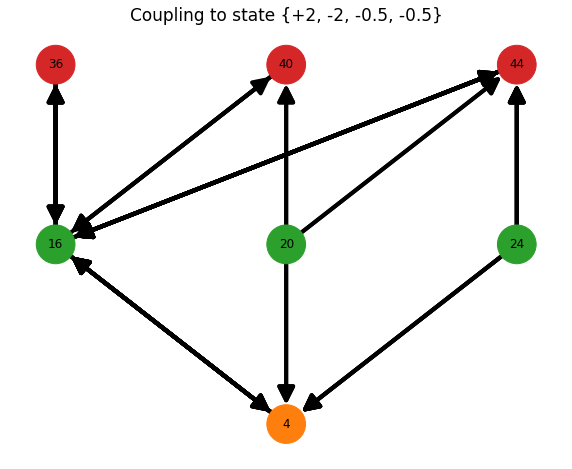

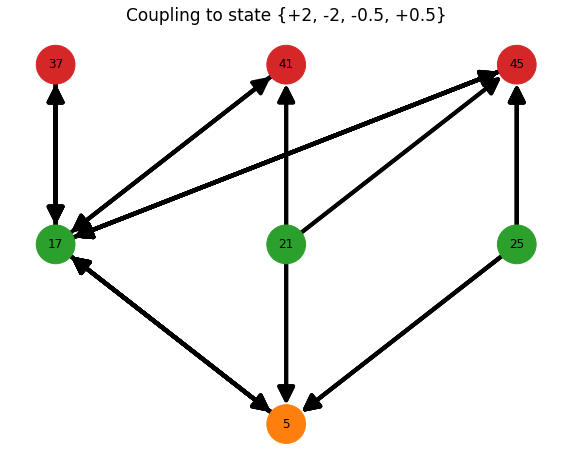

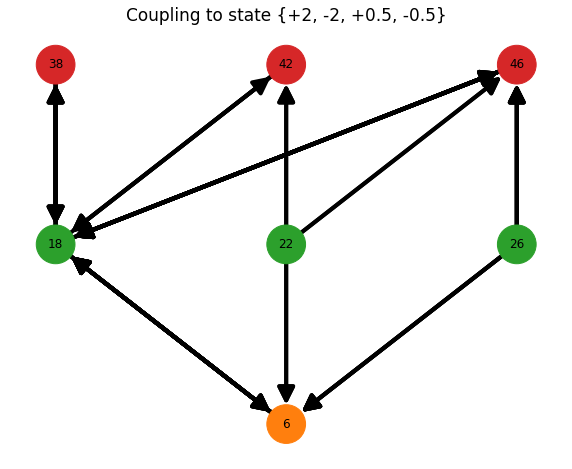

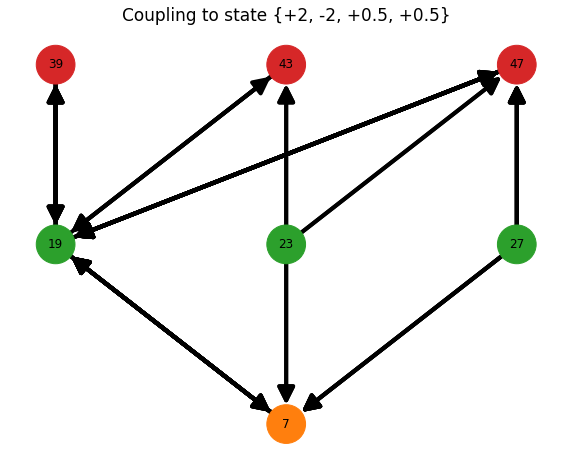

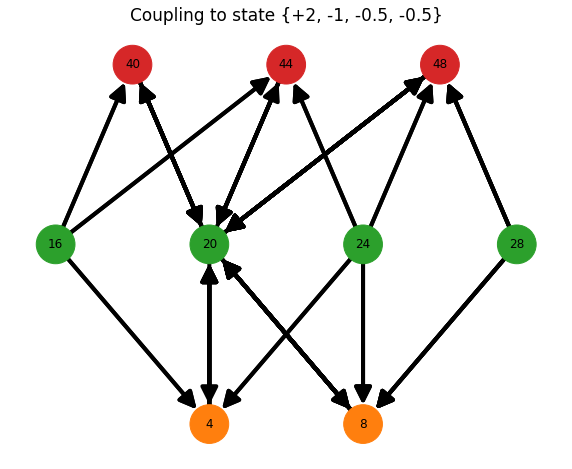

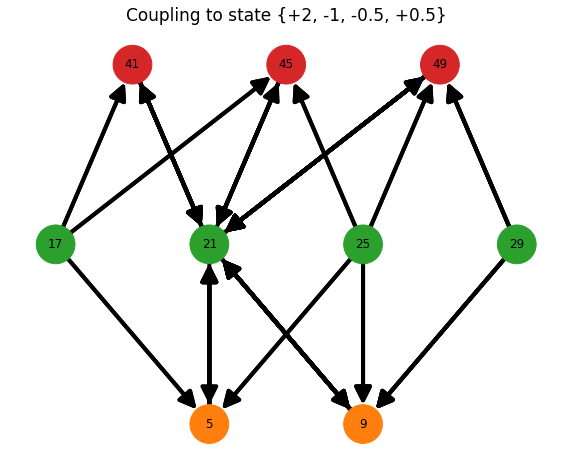

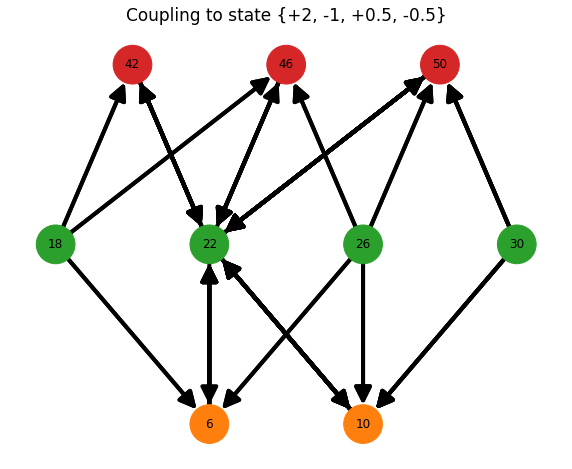

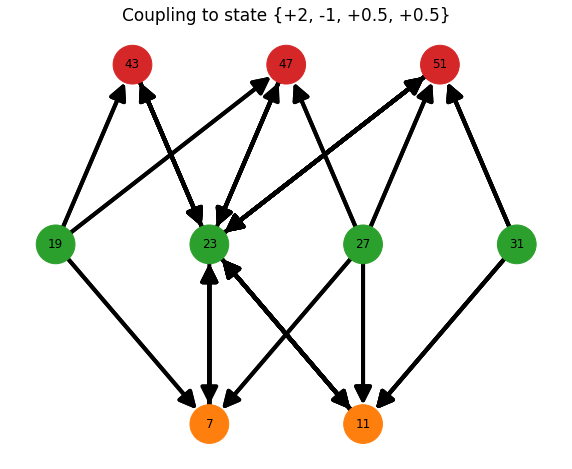

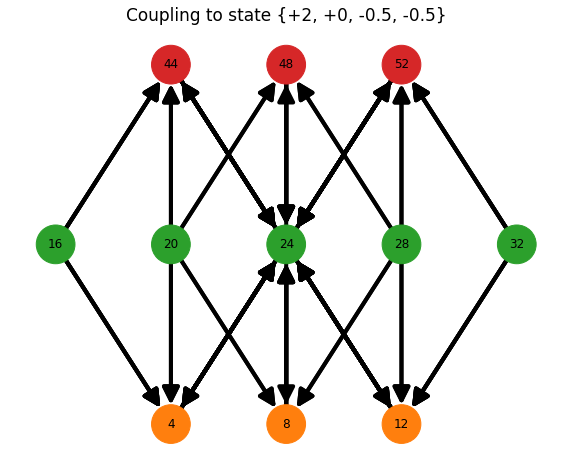

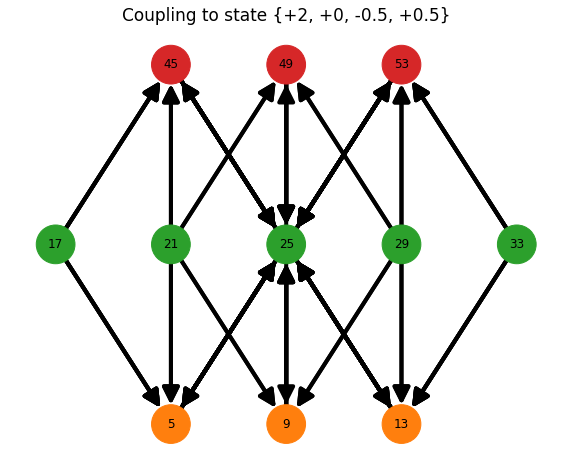

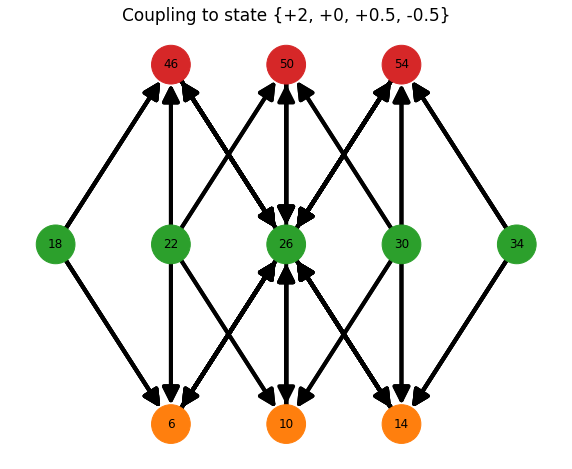

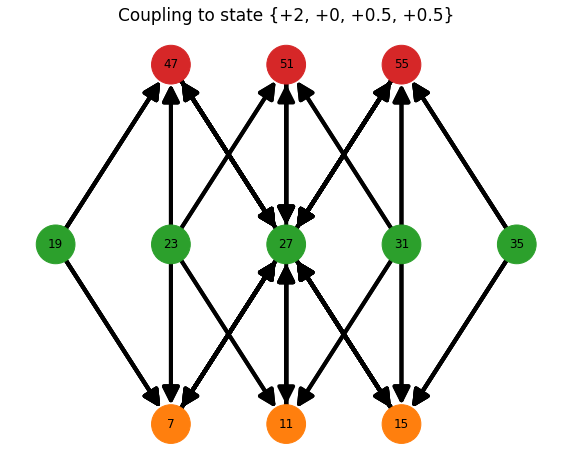

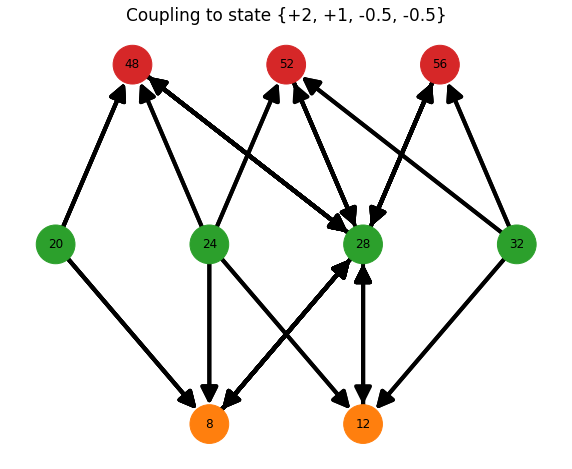

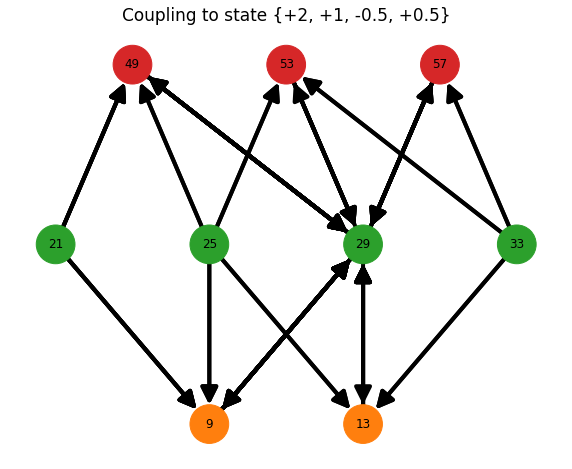

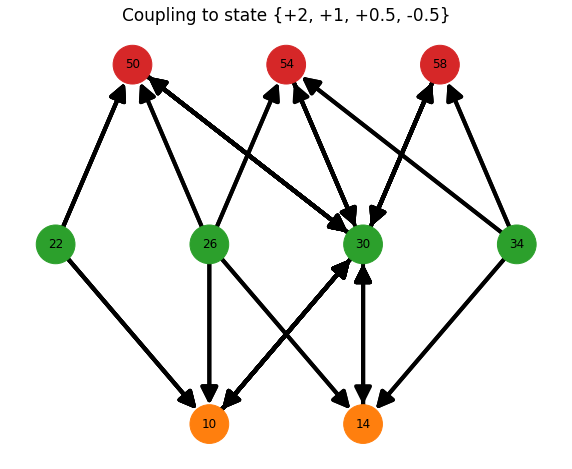

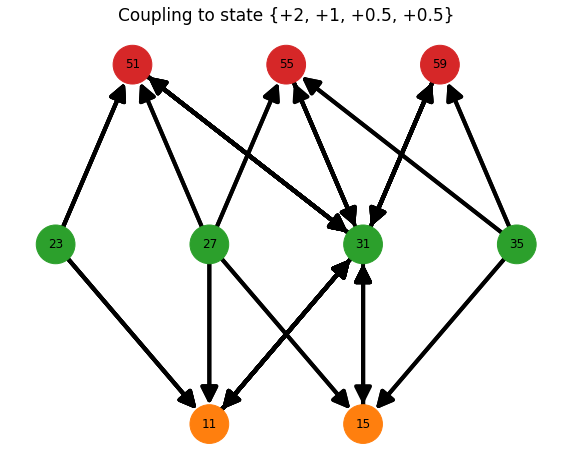

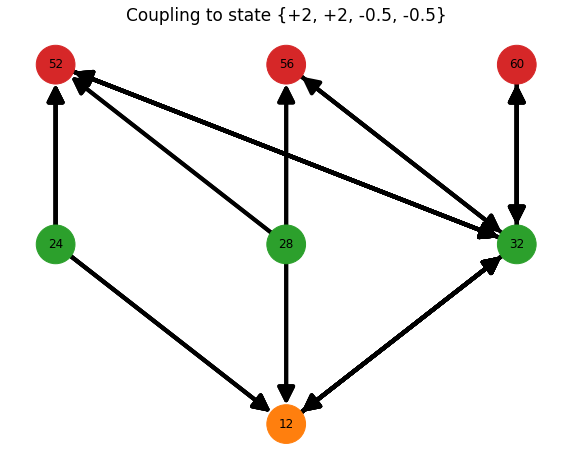

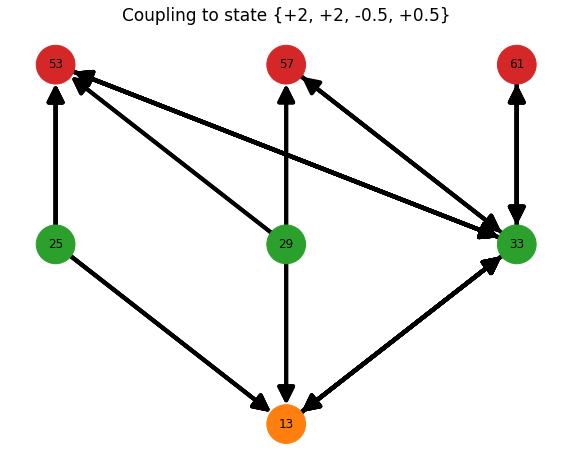

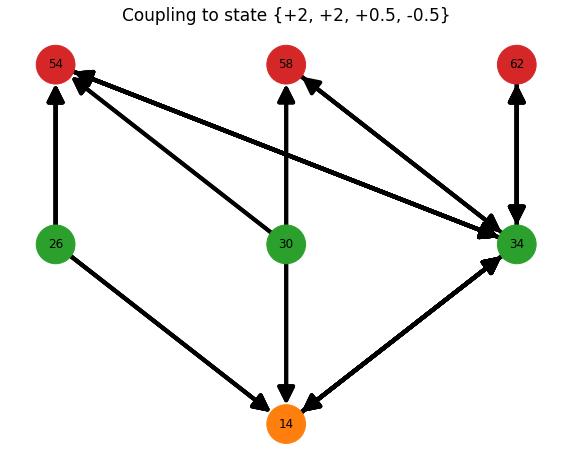

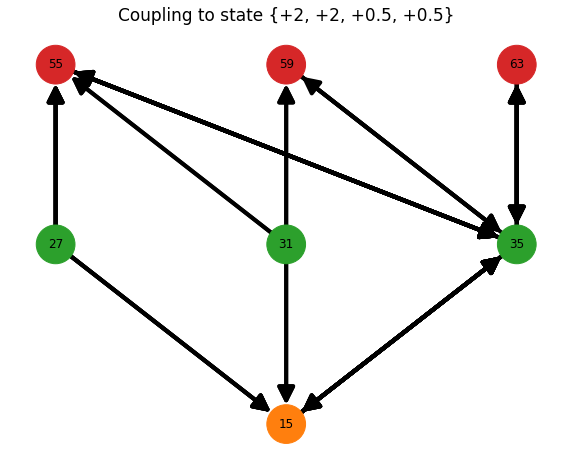

In [703]:
# import pygraphviz
import matplotlib.colors as colors
from matplotlib import cm

graph_dict = connected_graphs_target_coupling

for target in graph_dict.keys():
    graph = nx.MultiDiGraph()
    for coupling in sorted(graph_dict[target].keys()):
        cn = graph_dict[target][coupling].copy()
        for node, attr in cn.nodes(data = True):
            graph.add_node(node, **attr)
        for source, target, attr in cn.edges(data =True):
            graph.add_edge(source, target, **attr)
    
    color_mapping = {0:'C0', 1:'C1', 2:'C2', 3:'C3'}
    node_colors = list(nx.get_node_attributes(graph,'J').values())
    node_colors = [color_mapping[n] for n in node_colors]
    
    edge_dict = dict((coupling, idx) for idx, coupling in enumerate(np.unique(list(nx.get_edge_attributes(graph, 'coupling').values()))))
    edge_colors = [cm.tab20c(edge_dict[coupling]) for coupling in nx.get_edge_attributes(graph, 'coupling').values()]

#     node_labels = dict((node, 
    node_labels = dict(((node, f"{int(data['mJ']):+d}, {float(data['m1']):+.1f}, {float(data['m2']):+.1f}") for node, data in graph.nodes(data = True)))
    
    fig,ax = plt.subplots(figsize = (10,8))
    ax.set_title(f'Coupling to state {{{QN[target].J:+1}, {QN[target].mJ:+1d}, {QN[target].m1:+.1f}, {QN[target].m2:+.1f}}}', 
                 fontsize = 17)
    pos = nx.spring_layout(graph)
    
    x_pos = get_node_x_positions(graph)
    for node, J in nx.get_node_attributes(graph, 'J').items():
        pos[node] = (x_pos[node],J-2)
    
    nx.draw(graph,pos, node_size = 1500, width = 4, with_labels=True, node_color = node_colors, arrowsize = 35)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


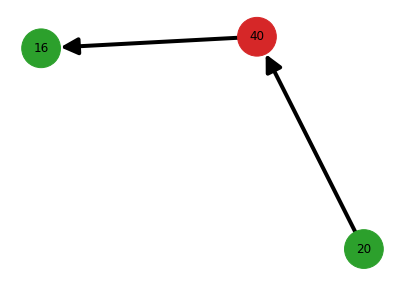

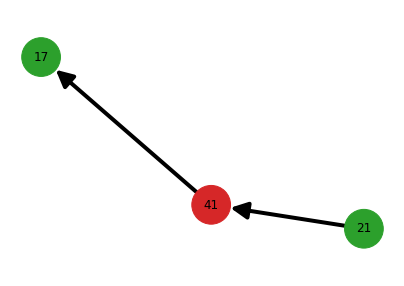

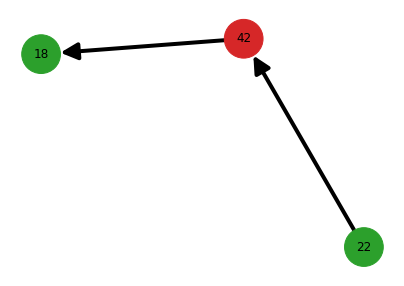

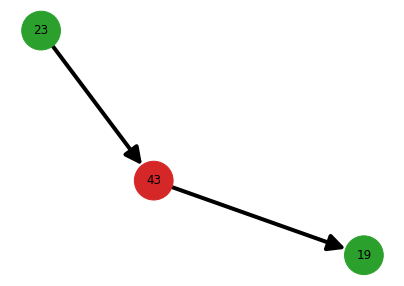

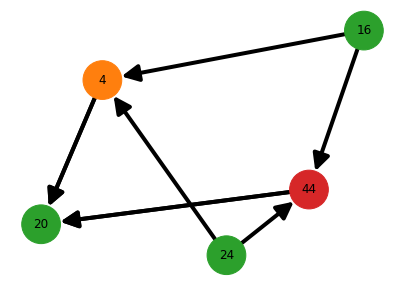

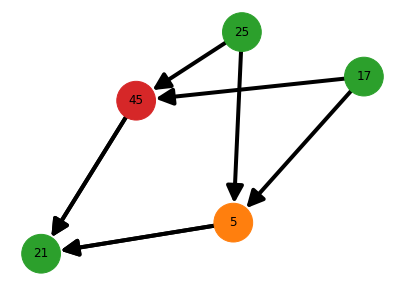

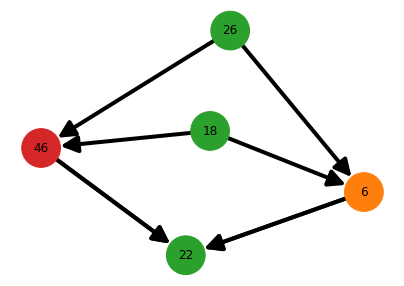

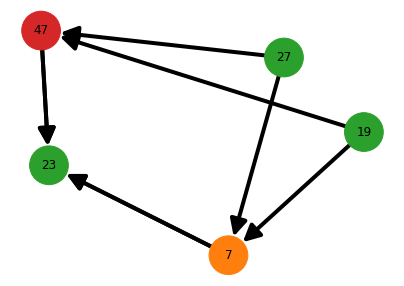

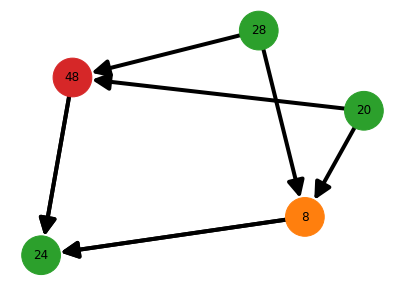

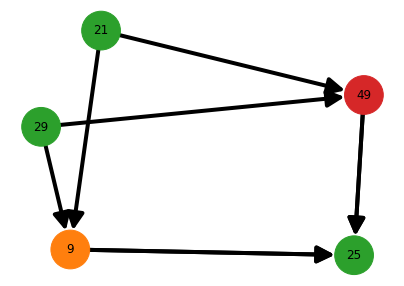

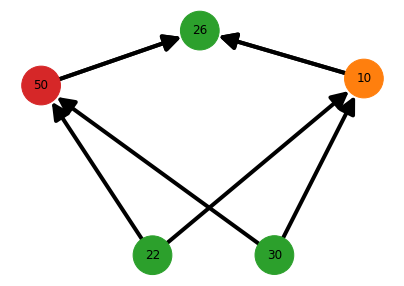

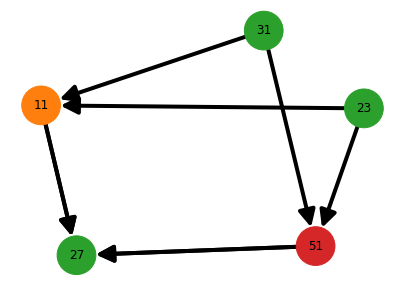

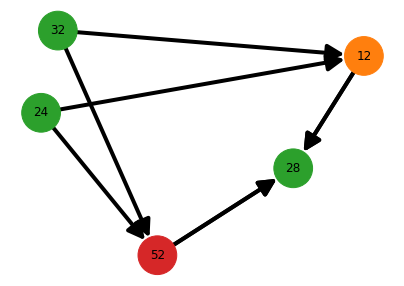

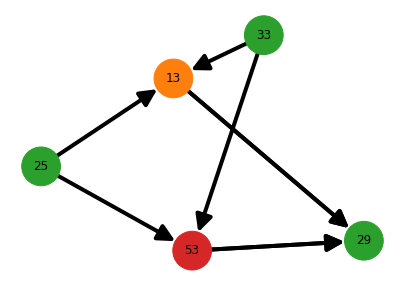

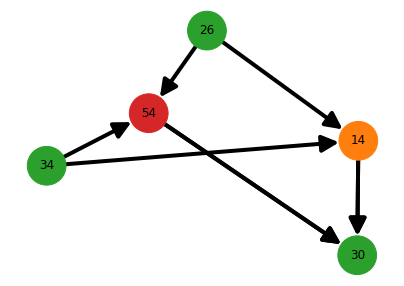

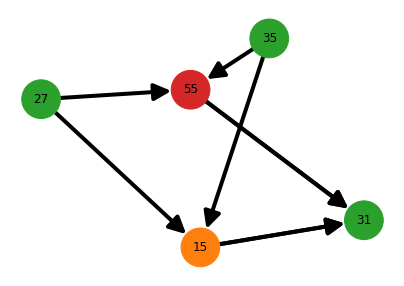

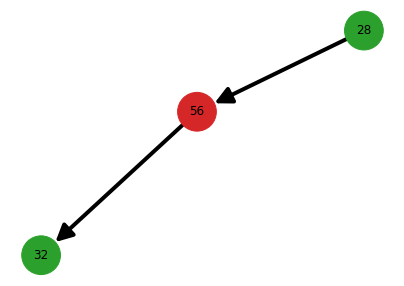

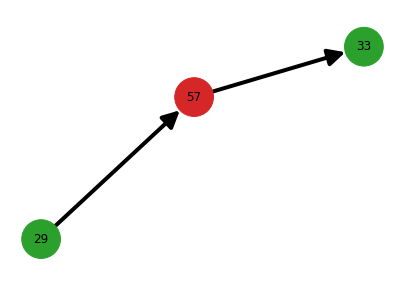

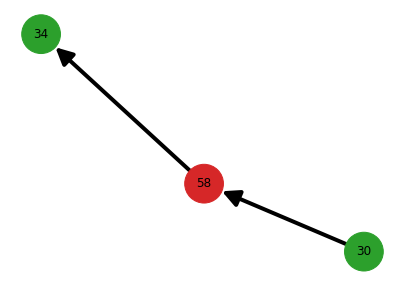

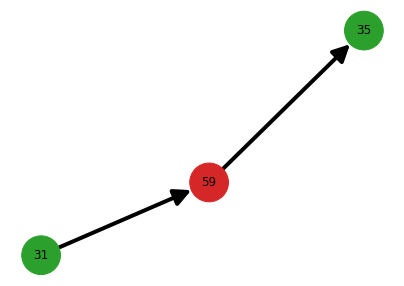

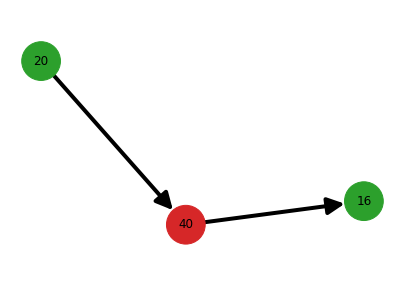

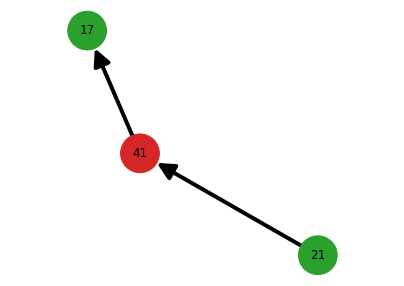

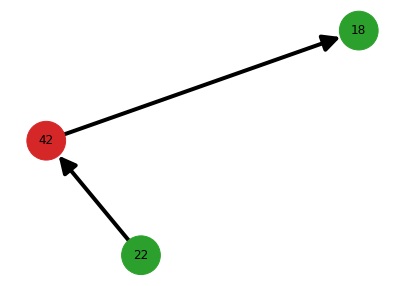

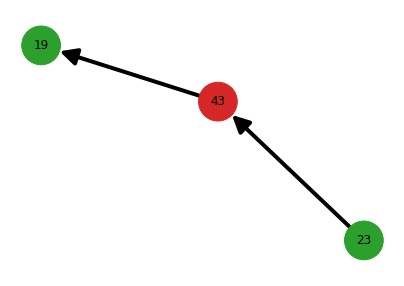

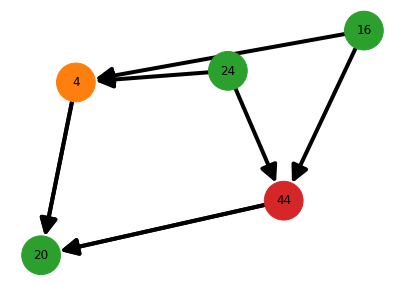

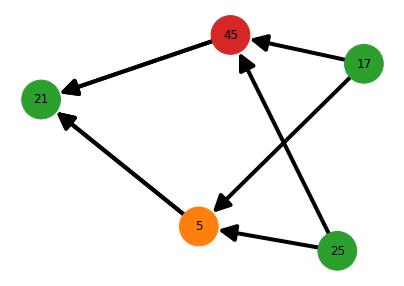

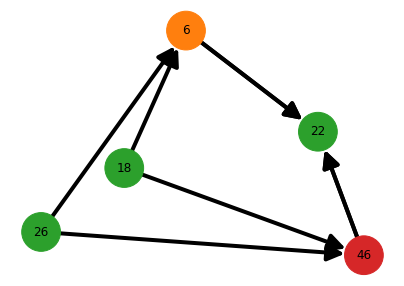

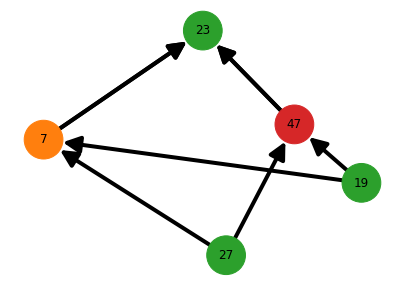

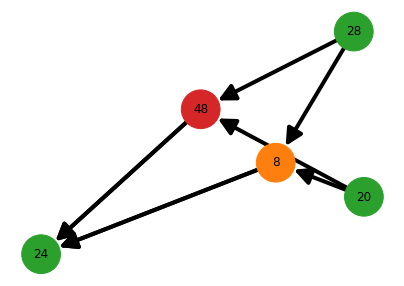

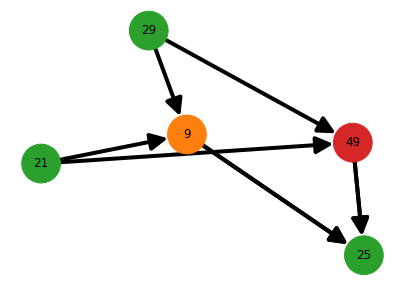

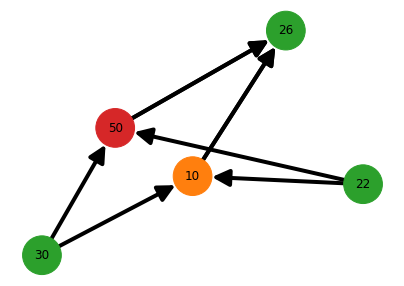

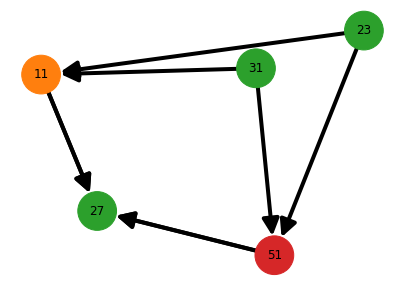

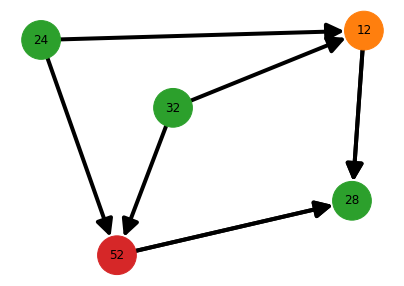

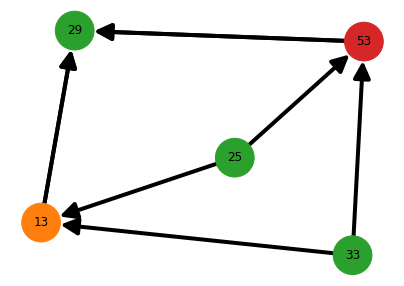

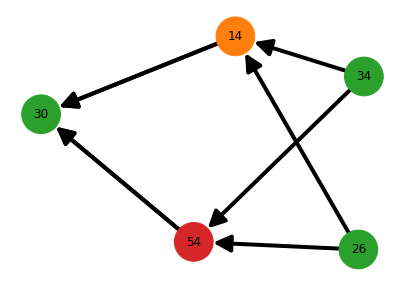

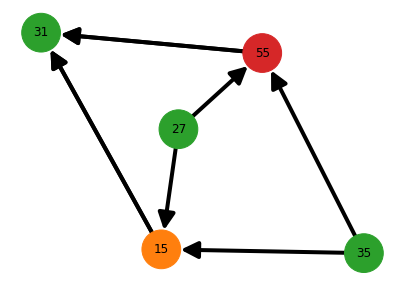

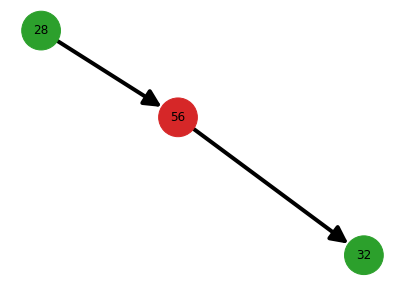

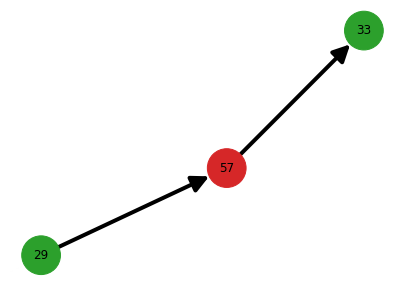

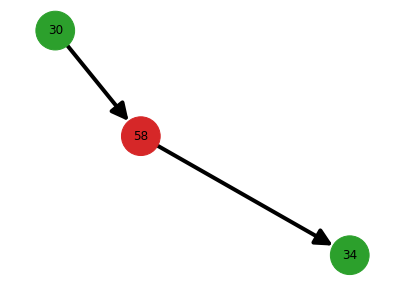

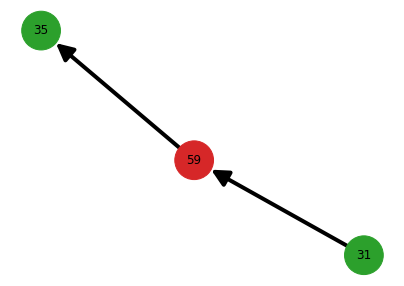

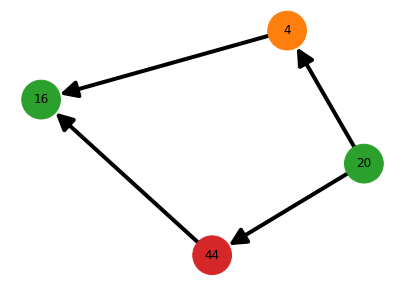

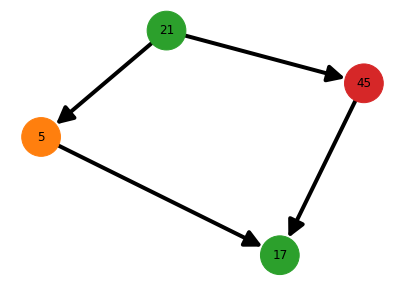

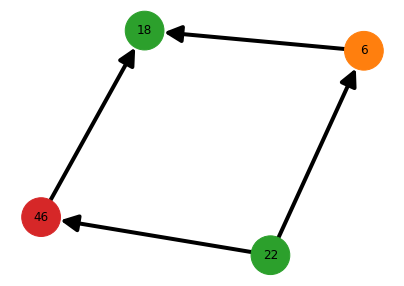

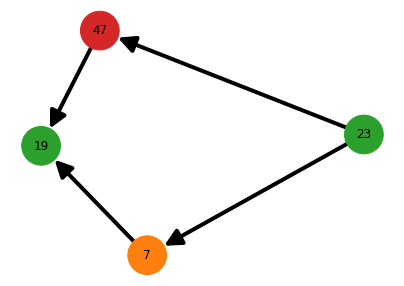

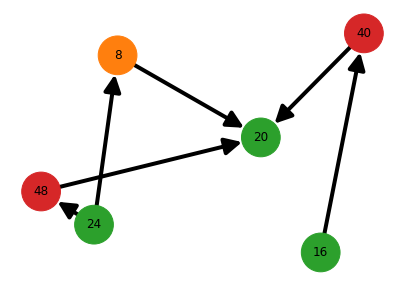

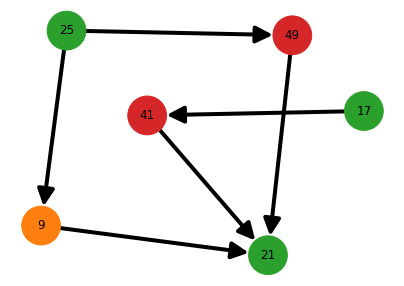

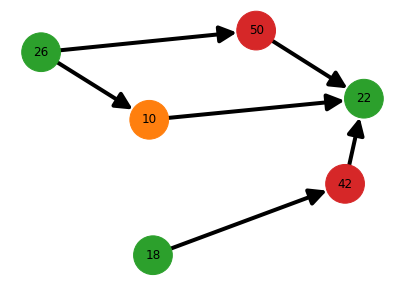

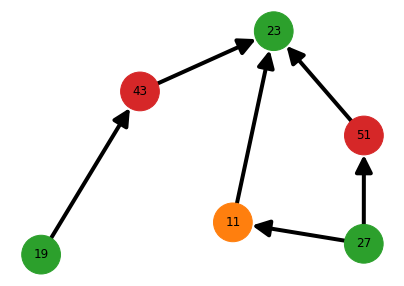

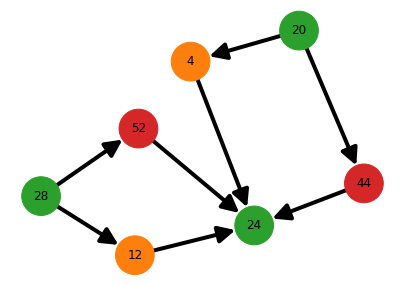

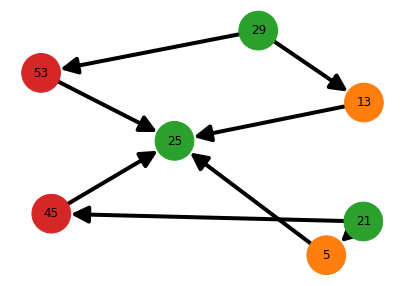

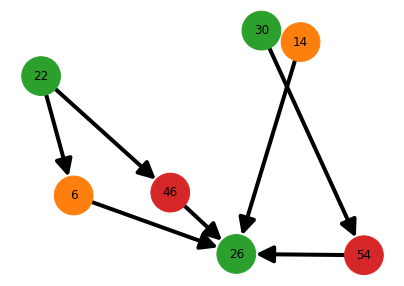

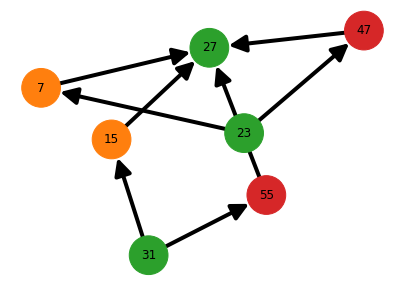

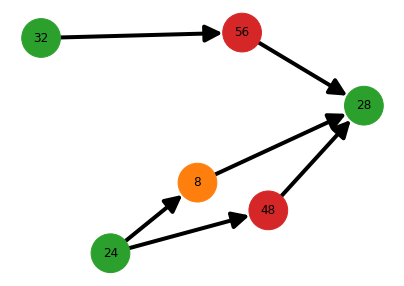

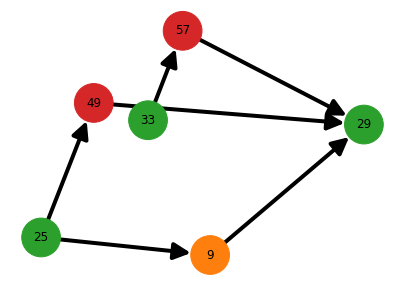

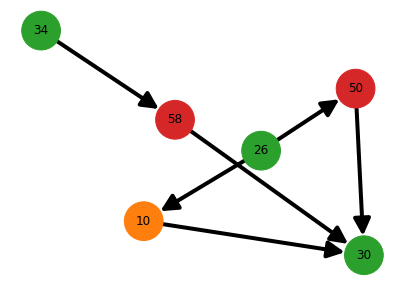

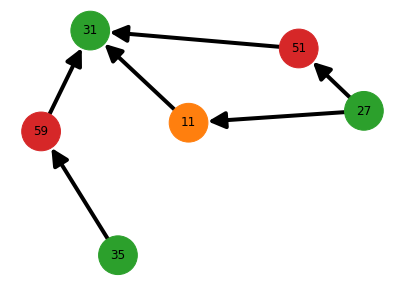

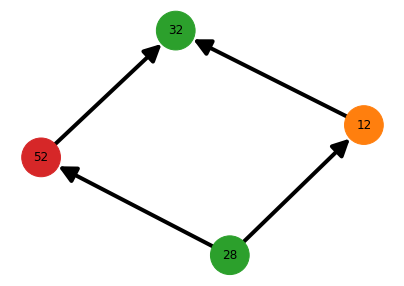

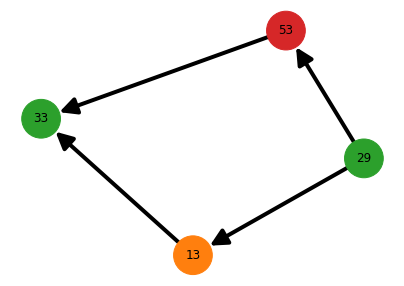

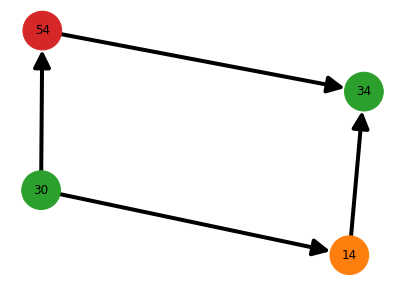

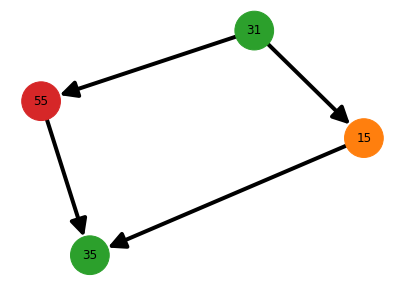

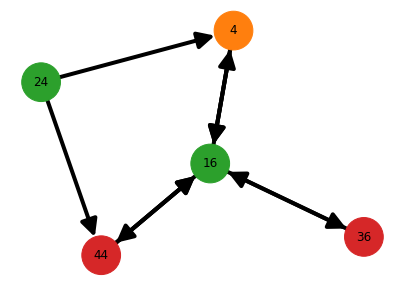

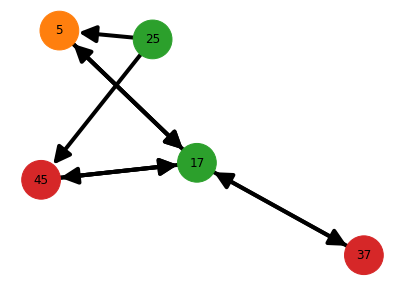

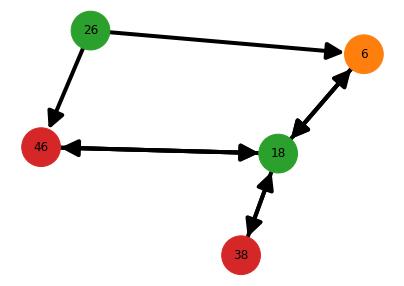

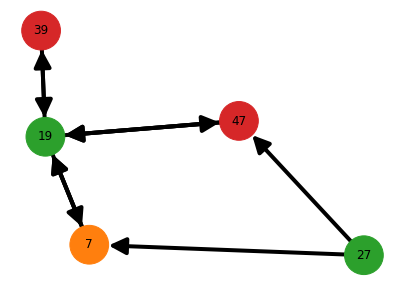

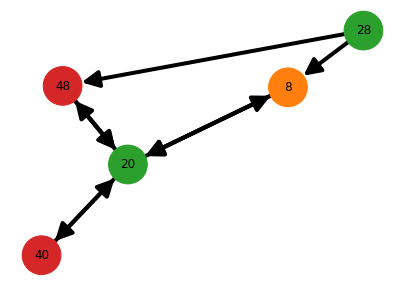

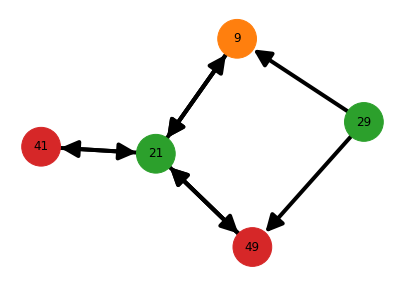

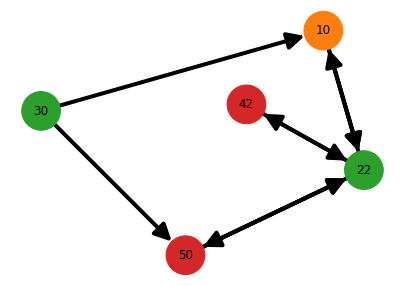

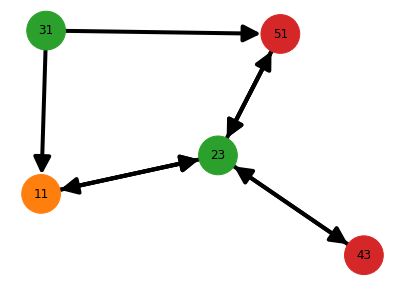

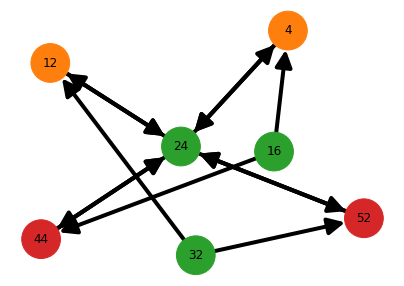

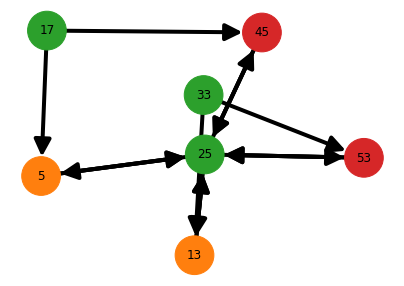

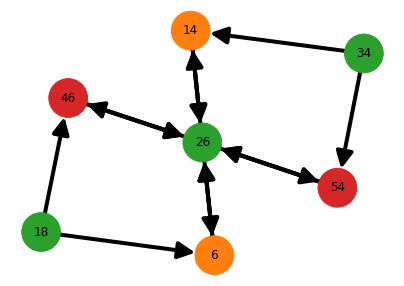

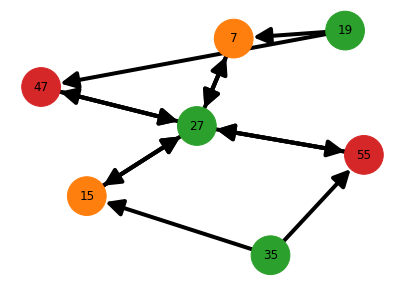

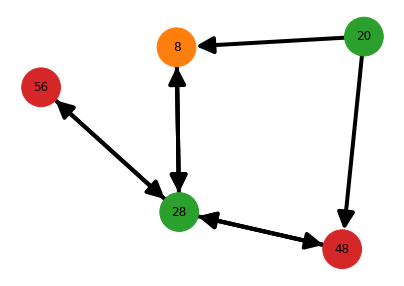

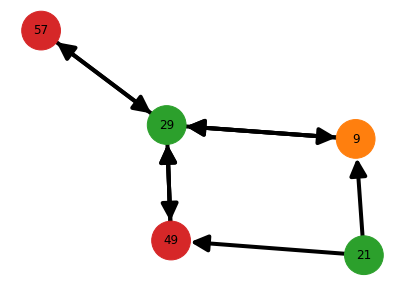

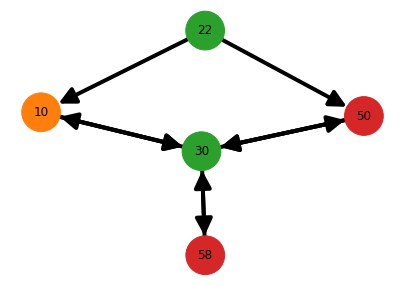

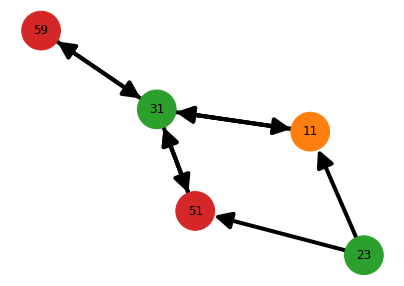

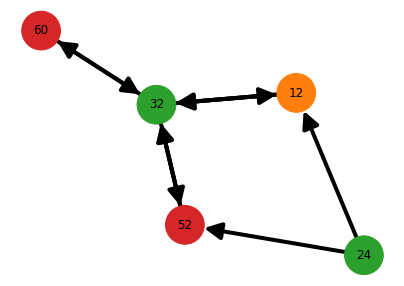

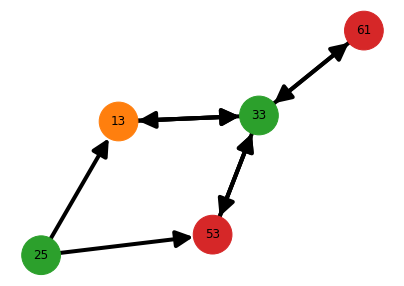

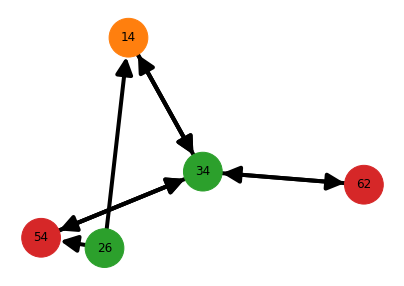

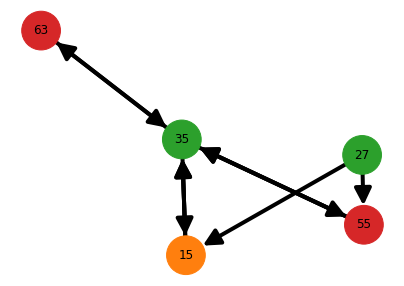

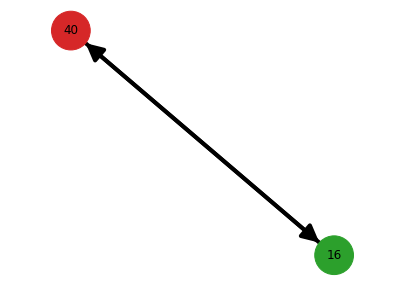

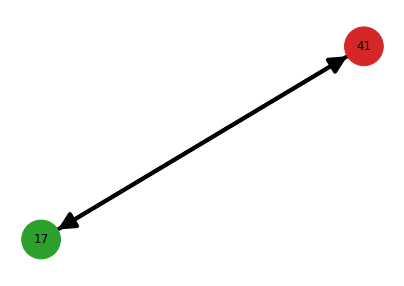

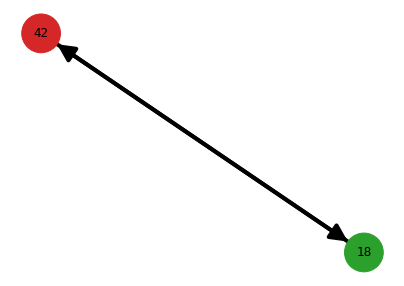

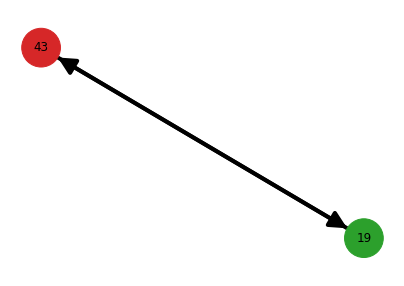

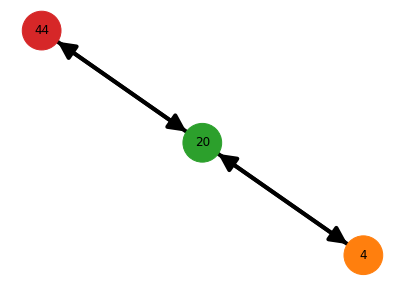

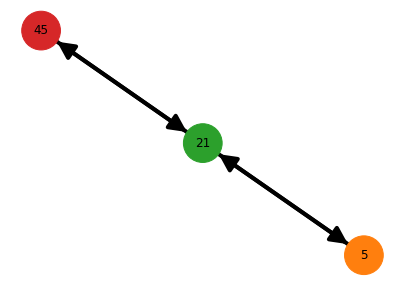

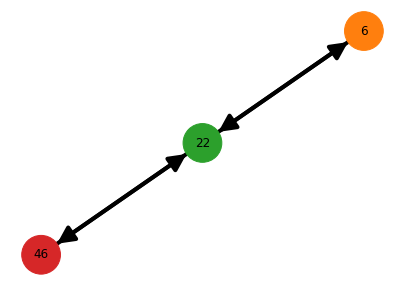

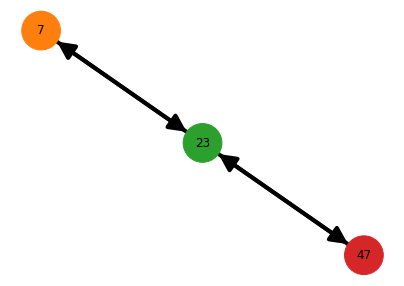

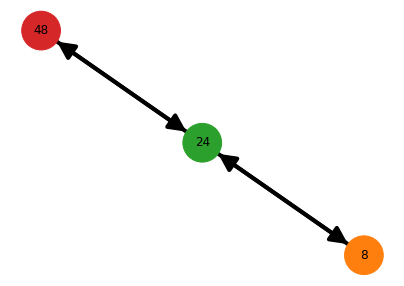

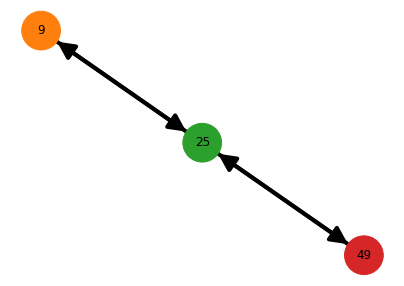

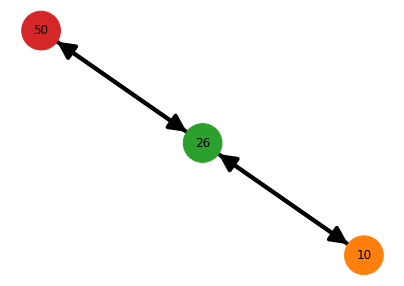

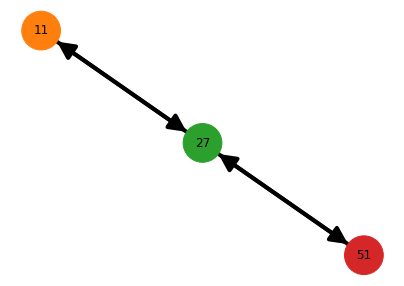

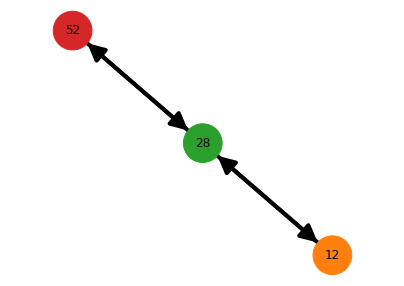

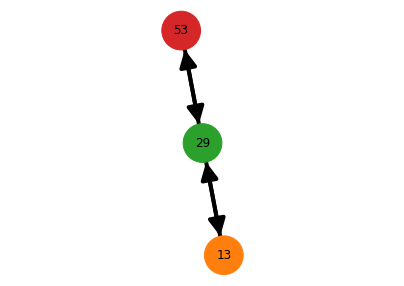

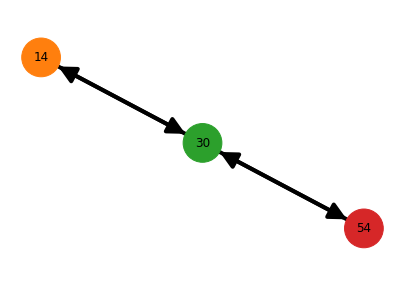

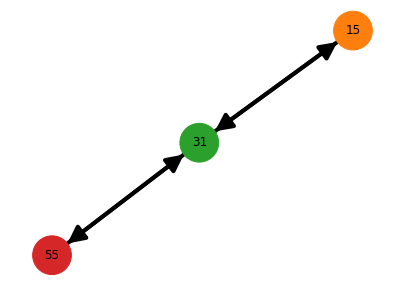

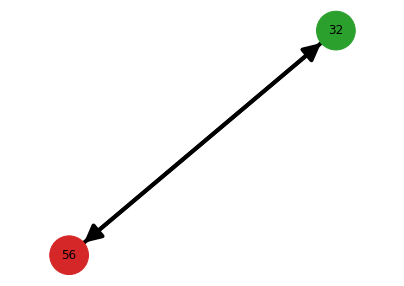

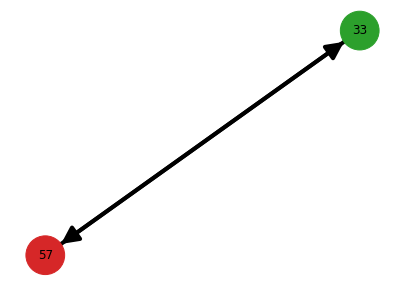

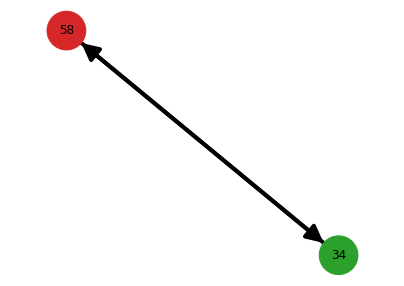

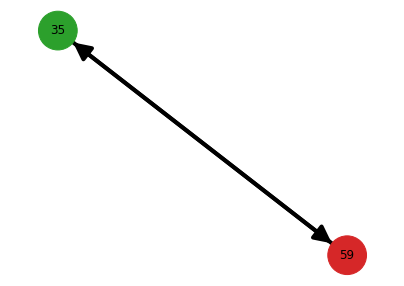

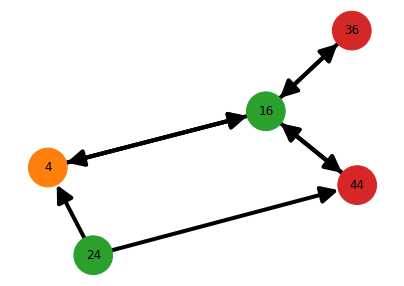

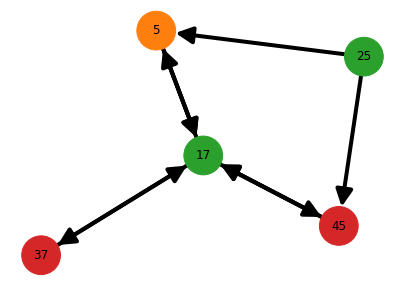

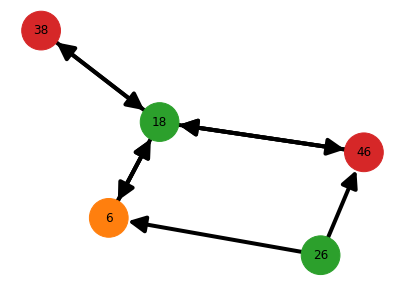

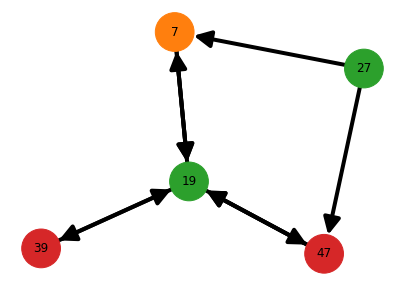

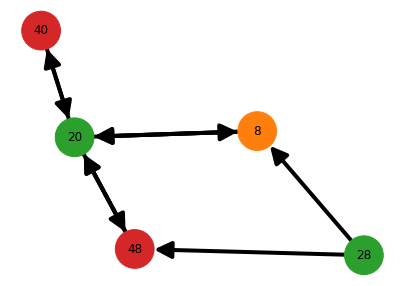

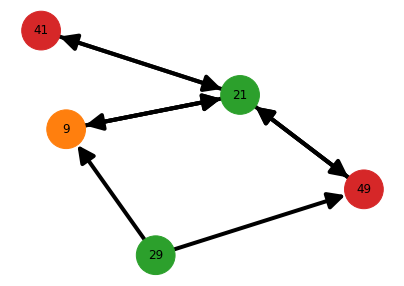

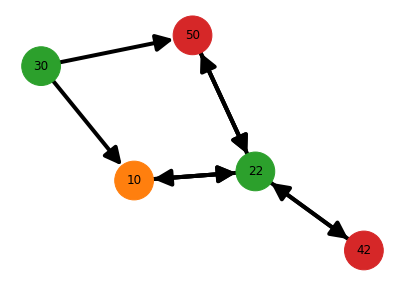

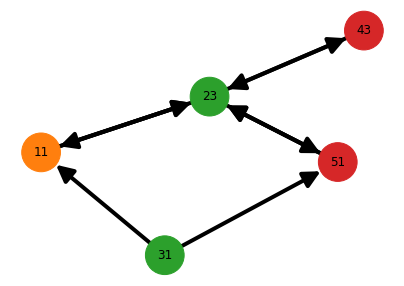

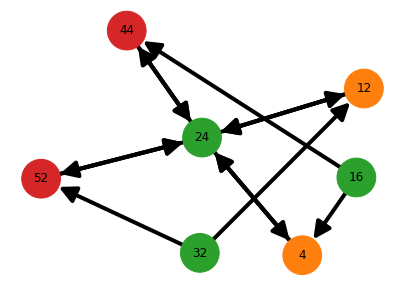

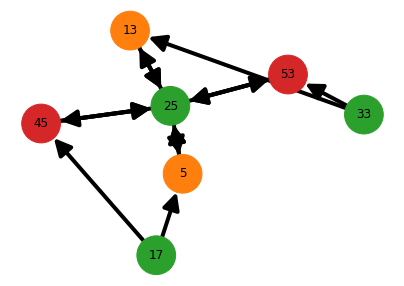

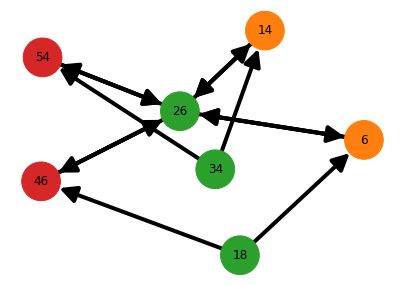

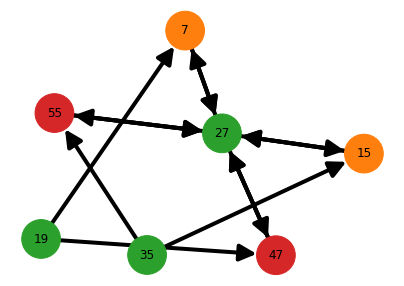

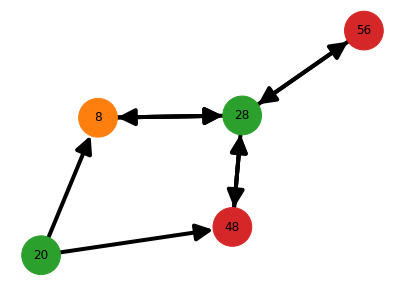

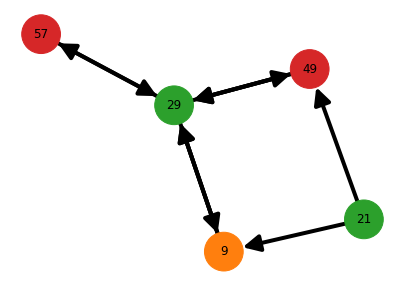

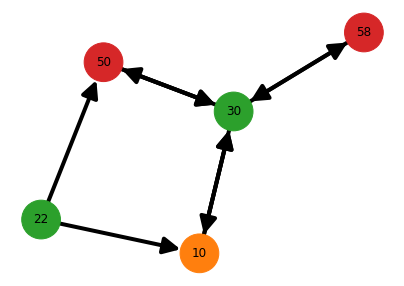

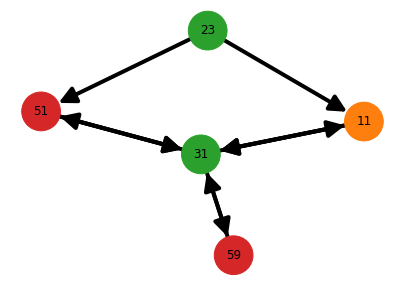

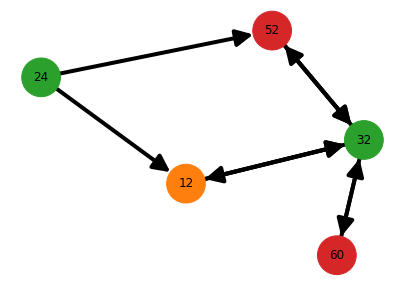

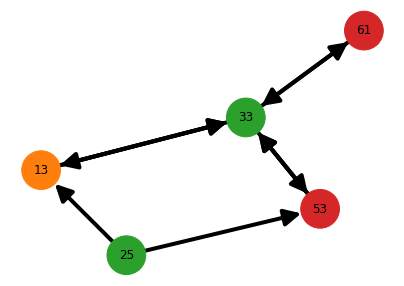

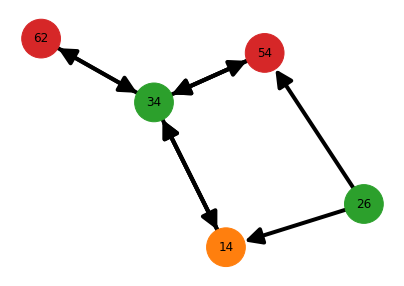

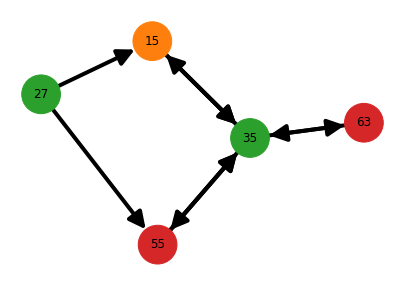

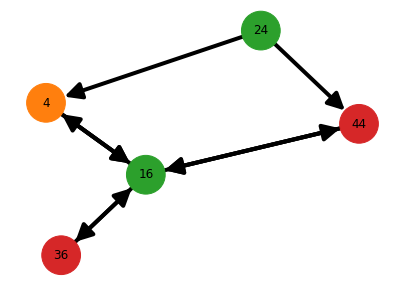

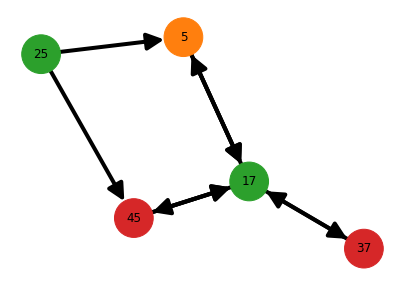

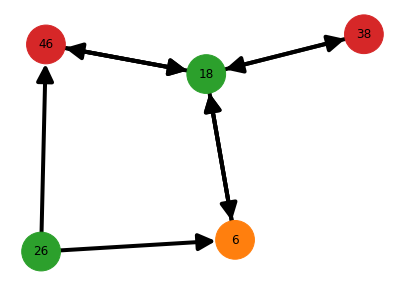

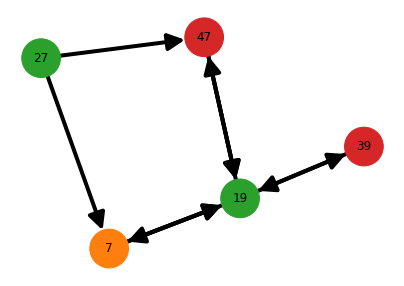

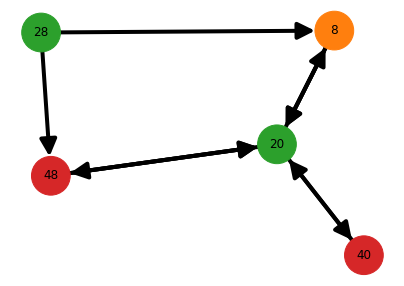

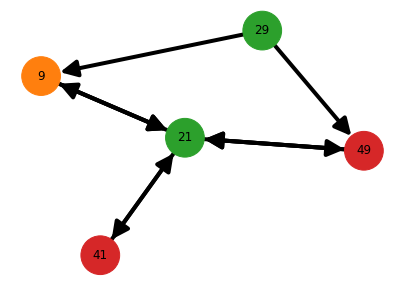

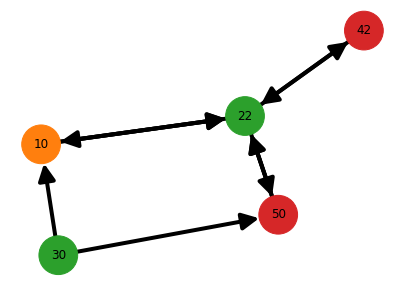

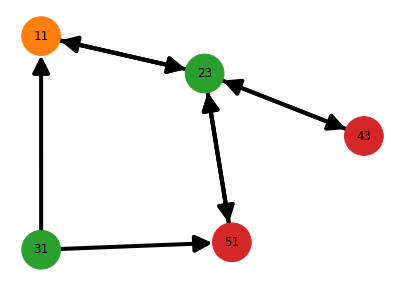

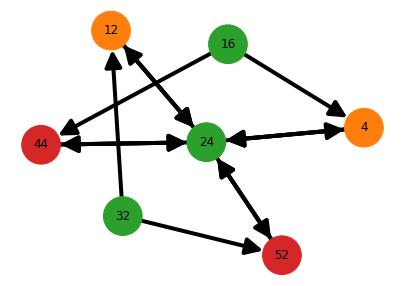

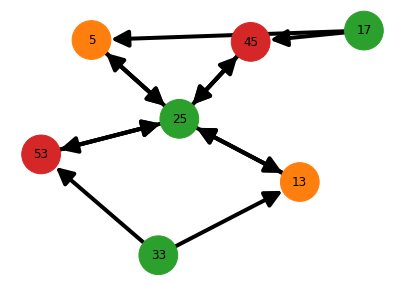

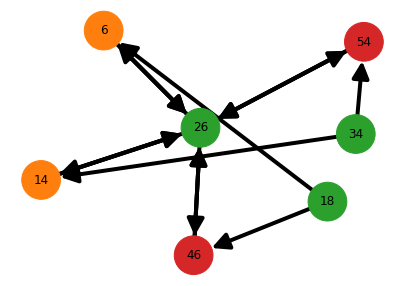

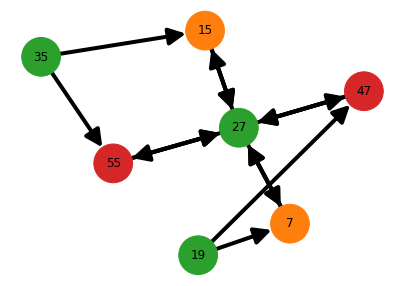

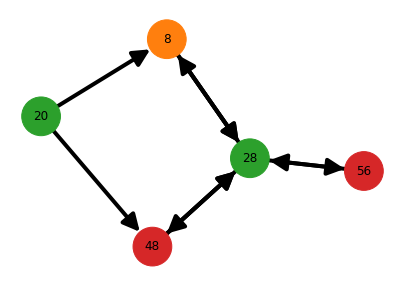

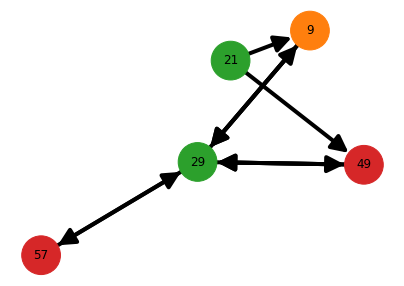

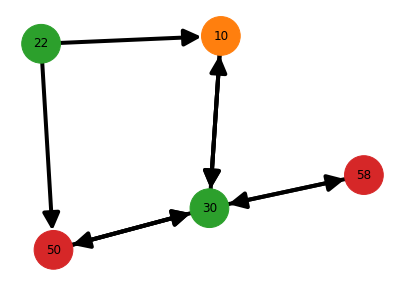

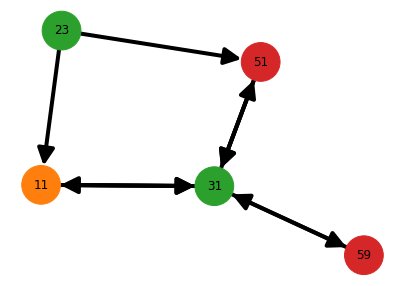

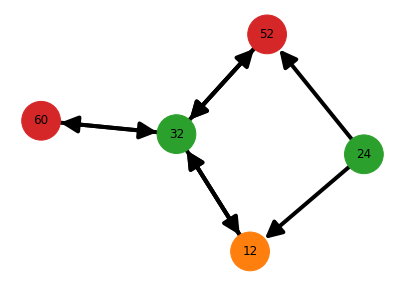

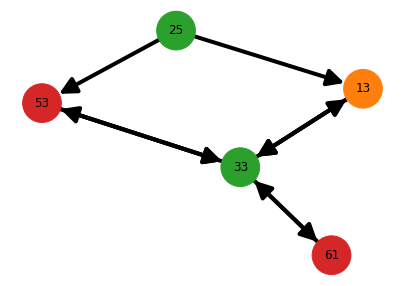

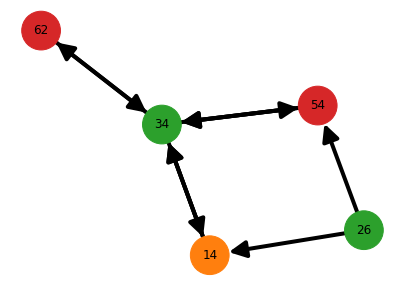

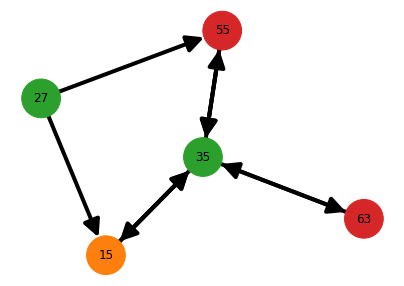

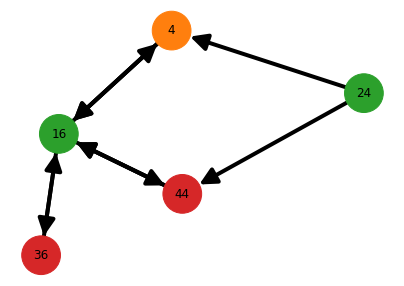

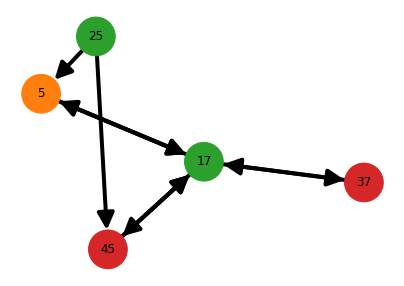

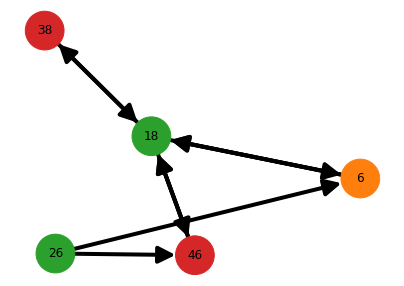

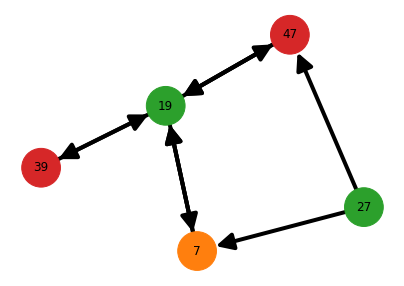

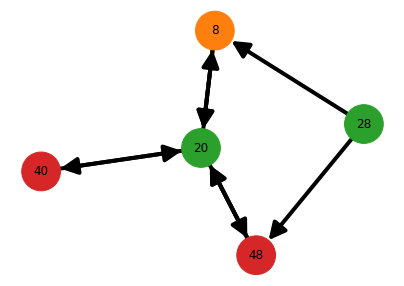

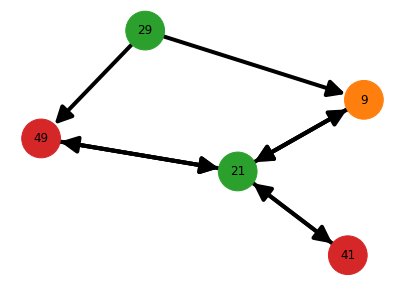

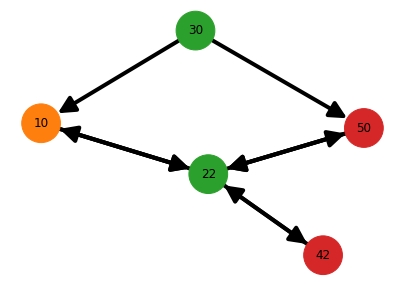

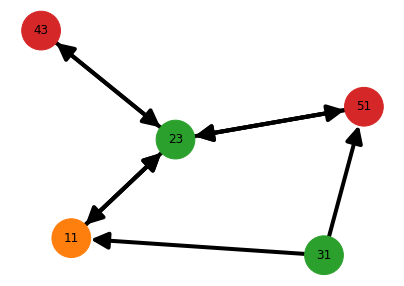

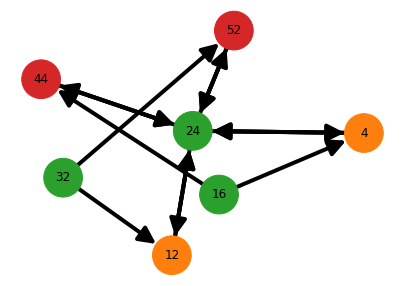

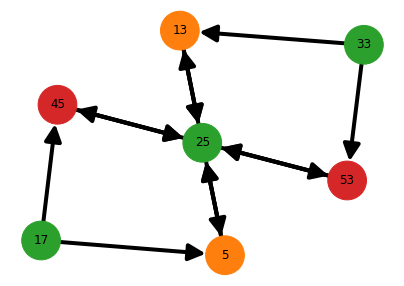

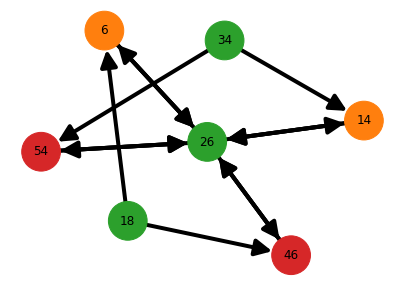

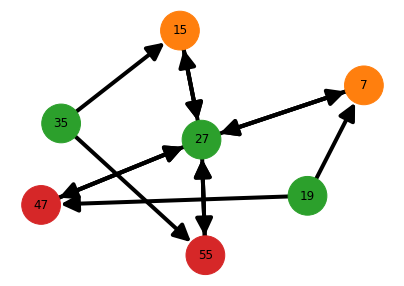

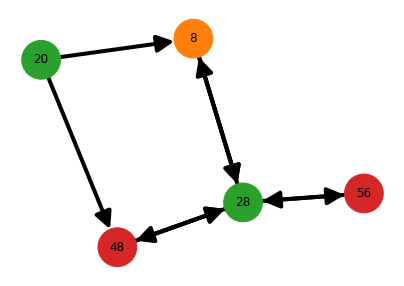

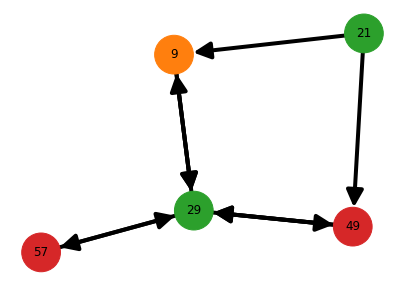

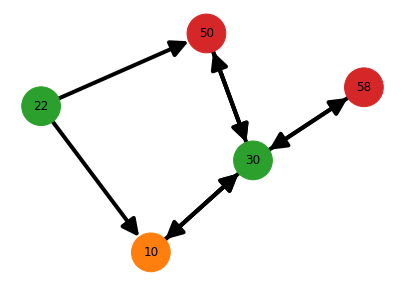

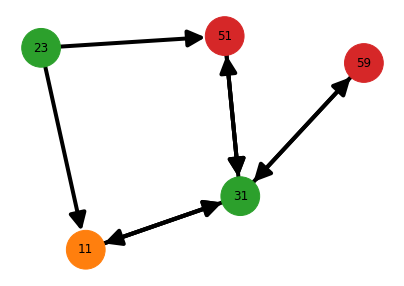

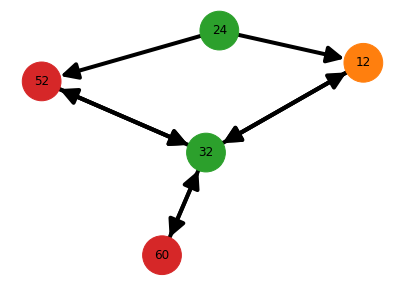

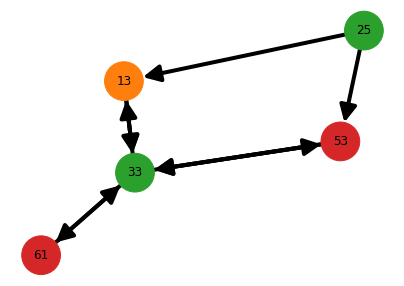

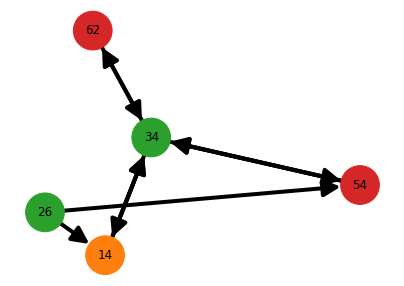

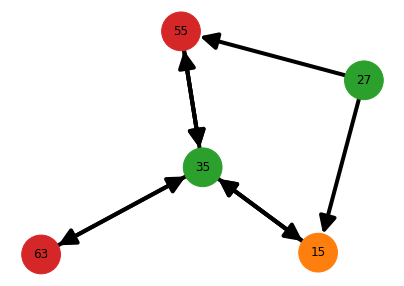

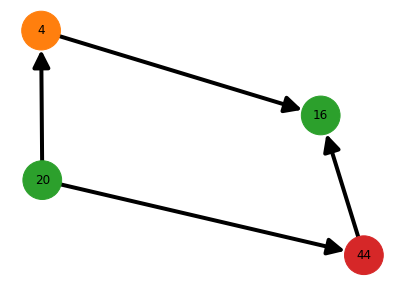

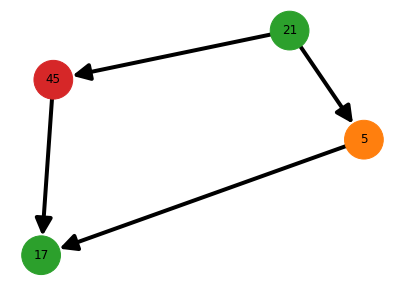

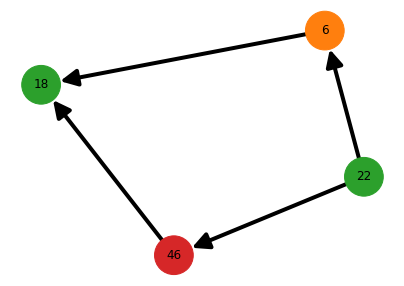

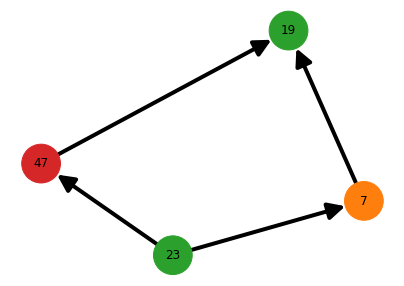

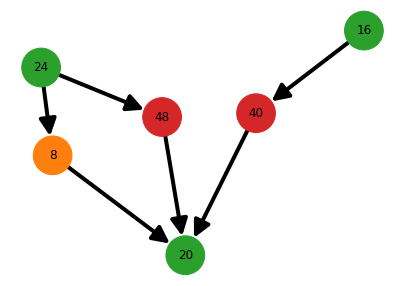

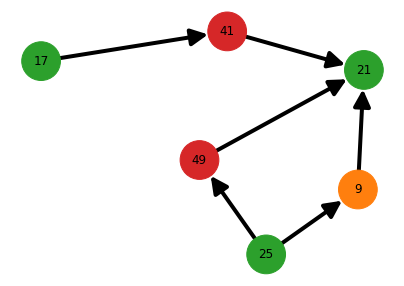

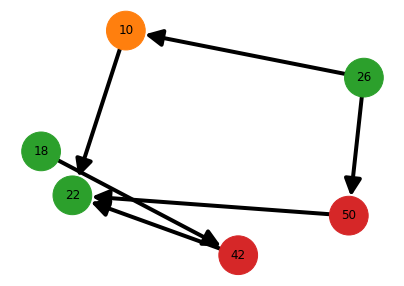

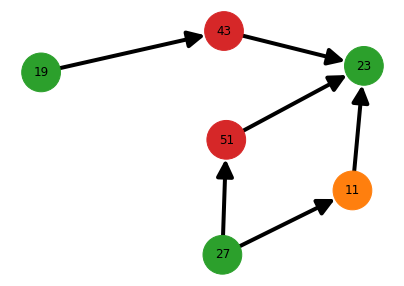

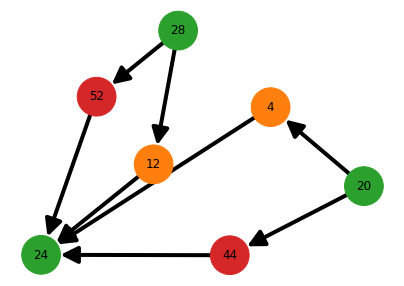

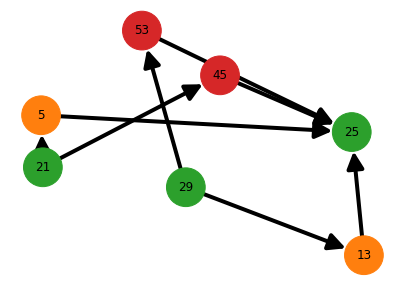

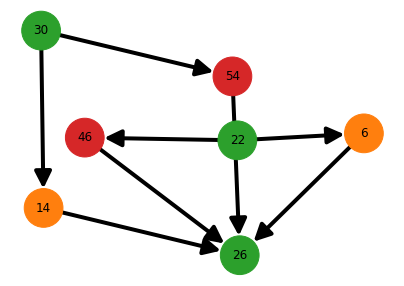

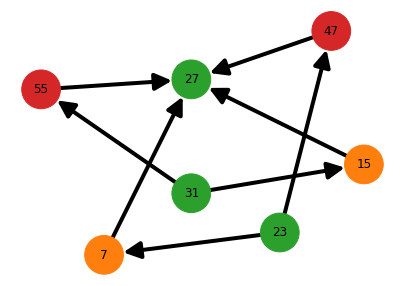

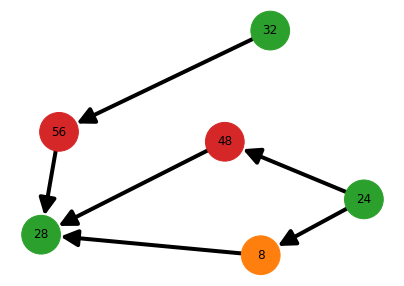

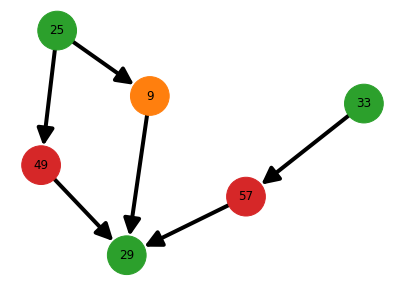

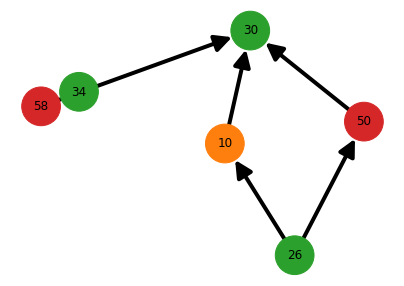

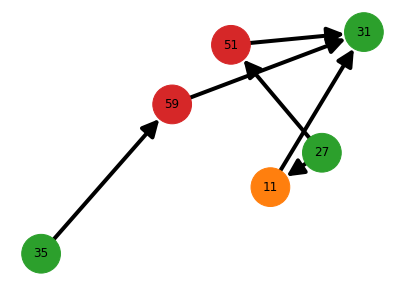

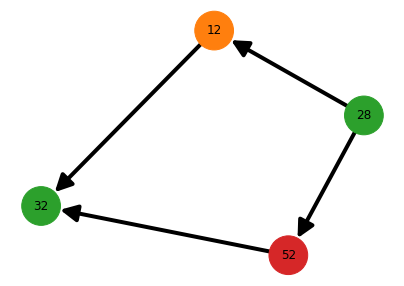

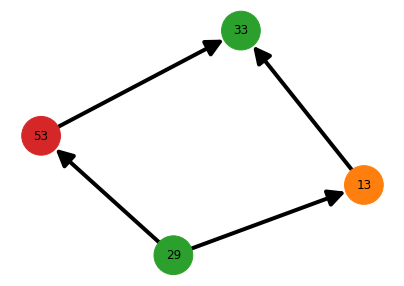

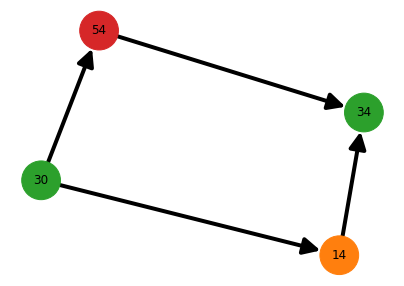

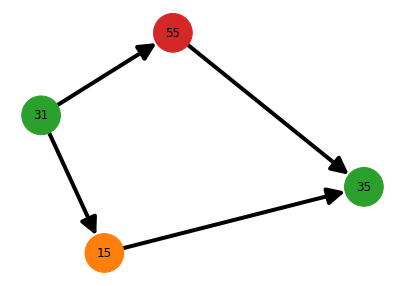

In [507]:
# import pygraphviz
import matplotlib.colors as colors
from matplotlib import cm

for coupling in connected_graphs.keys():
    for target in sorted(connected_graphs[coupling].keys()):
        cn = connected_graphs[coupling][target]
#         edges, directions, couplings, labels = set_path_couplings_direction(get_couplings_paths(connected_graphs[target], 
#                                                                     find_paths_digraph(connected_graphs[target],target,2)))
        color_mapping = {0:'C0', 1:'C1', 2:'C2', 3:'C3'}
        node_colors = list(nx.get_node_attributes(cn,'J').values())
        node_colors = [color_mapping[n] for n in node_colors]
        
    #     edge_colors = [cm.viridis(coupling) for coupling in normalize_list(couplings)]
#         edge_colors = [cm.tab20b(label) for label in normalize_list(labels)]

    #     edges, edge_colors = zip(*nx.get_edge_attributes(cn, 'coupling').items())
    #     edge_colors = normalize_list([np.abs(c) for c in edge_colors])
    #     edge_colors = np.array(edge_colors).astype(float)

        fig,ax = plt.subplots(figsize = (7,5))

        nx.draw(cn, node_size = 1500, width = 4, with_labels=True, node_color = node_colors, arrowsize = 35)
    #     sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = min(edge_colors), vmax=max(edge_colors)))
    #     nx.draw(cn, node_size = 1500, width = 4, with_labels=True, node_color = node_colors, arrowsize = 35,
    #             edgelist = edges, edge_color = edge_colors)
    #     fig.colorbar(sm)
#         a = nx.nx_agraph.to_agraph(cn)
#         a.graph_attr['dpi'] = 300
#     #     a.graph_attr['concentrate'] = True
#         a.node_attr['style']='filled'
#     #     a.node_attr['shape']='oval'
#         for n in a.nodes():
#             set_node_color(n)
#             set_node_label(n)
#         a.get_node(target).attr['style'] = "filled,dashed"
#         a.get_node(target).attr['penwidth'] = 2.5
#         for edge in a.edges():
#             a.delete_edge(edge)
#         for coupling, edge, direction, label, color in zip(couplings, edges, directions, labels, edge_colors):
#             a.add_edge(*edge)
#             a.get_edge(*edge).attr['penwidth'] = coupling
#             a.get_edge(*edge).attr['dir'] = direction
#     #         a.get_edge(*edge).attr['label'] = f'{label}'
#             a.get_edge(*edge).attr['color'] = colors.to_hex(color)
#         a.draw(graph_dir + f'{target}.png', prog = 'dot')

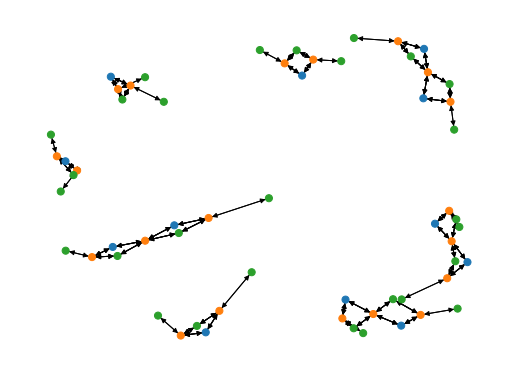

In [58]:
color_mapping = {1:'C0', 2:'C1', 3:'C2'}
node_colors = list(nx.get_node_attributes(graph,'J').values())
node_colors = [color_mapping[n] for n in node_colors]

pos = nx.spring_layout(graph,k=0.5,iterations=120)

plt.figure(figsize = (7,5))
nx.draw(graph, node_size = 50, width = 1, with_labels=False, node_color = node_colors, pos = pos)

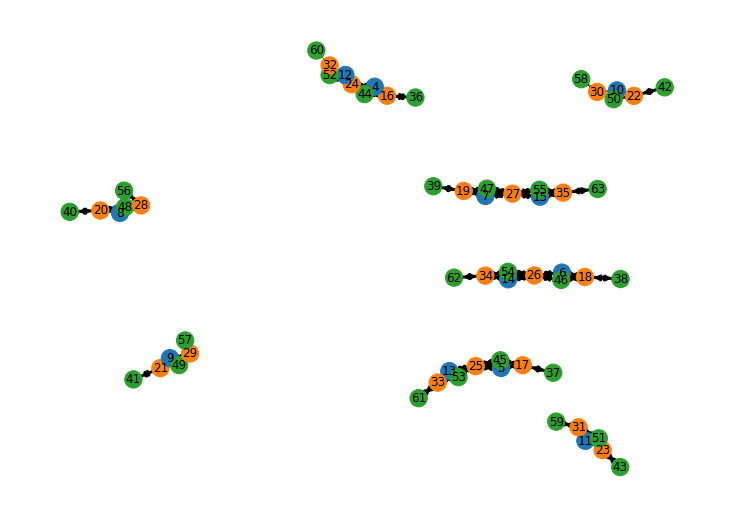

In [57]:
color_mapping = {1:'C0', 2:'C1', 3:'C2'}
node_colors = list(nx.get_node_attributes(graph,'J').values())
node_colors = [color_mapping[n] for n in node_colors]

plt.figure(figsize = (10,7))
nx.draw(graph, node_size = 300, width = 3, with_labels=True, node_color = node_colors)

In [ ]:
plt.imshow(np.abs(Heff[1]['zz']))

In [ ]:
graph.edges[(40,16)]

In [ ]:
graph.edges[(16,40)]['coupling']*graph.edges[(40,16)]['coupling']

In [ ]:
(P0@HSz_m@Q0a@HSz_m@P0)[16:36,16:36][0,0]

In [ ]:
Heff_1st_HSz[0,0]

# Test symbolic for nodes

In [ ]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    """
    Compressing variable permutations into one matrix, e.g. xy, yx -> xy.
    """
    ax = list(d.keys())
    for axes in ax:
        for c in itertools.permutations(axes):
            c = ''.join(c)
            if c != axes:
                if not isinstance(d.get(c), type(None)):
                    d[axes] += d[c]
                    ax.remove(c)
                    del d[c]
    return d

def generate_effective_hamiltonian_symbolic(H0, variables, Hpertubations, J = 2, order = 2, Jmax = 6):
    """"
    Function to generate the effective Hamiltonian in the specified J state
    
    H0            : unperturbed Hamiltonian  
    variables     : list of variables corresponding to the list of Hpertubations
    Hpertubations : list of perturbing Hamiltonians
    J             : J state to create effective Hamiltonian in
    order         : to which order to calculate the pertubation
    Jmax          : maximum J state in the unperturbed Hamiltonian
    
    See Brown-Carrington Chapter 7 a description of the derivation.
    """
    # determining the indices of the block corresponding to J
    idx_min, idx_max = index_range(J)
    
    # operator selecting only the J block matrix elements
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    # operator projecting off J block elements onto the J block
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    
    # calculating the contributing U terms 
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        print(f'calculating U({o})')
        U[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(variables, Hpertubations):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
        
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        U[o] = compress_variables(U[o])
    
    # generating the effective Hamiltonian
    Heff = dict()
    for o in range(order+1):
        print(f'calculating Heff({o})')
        Heff[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
    
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        Heff[o] = compress_variables(Heff[o])
                
    return U, Heff

In [ ]:
import sympy
from sympy import symbols

def generate_symbolic_hamiltonian(hamiltonians, hamiltonians_types,QN):
    hamiltonians_types_symbols = {}
    results = {}
    for Htype, H in zip(hamiltonians_types, hamiltonians):
        hamiltonians_types_symbols[Htype] = {}
        results[Htype] = np.zeros(H.shape, dtype = object)
        for i,j in zip(*np.where(H != 0)):
            symbi = f'<{QN[i].J};{QN[i].mJ};{QN[i].m1};{QN[i].m2}|'
            symbj = f'|{QN[j].J};{QN[j].mJ};{QN[j].m1};{QN[j].m2}>'
            symbol_name = symbi+Htype+symbj
            hamiltonians_types_symbols[Htype][symbol_name] = symbols(symbol_name)
            results[Htype][i,j] = hamiltonians_types_symbols[Htype][symbol_name]
    return hamiltonians_types_symbols, results

In [ ]:
import sympy
from sympy import symbols

def generate_symbolic_hamiltonian(hamiltonians, hamiltonians_types,QN):
    hamiltonians_types_symbols = {}
    results = {}
    for Htype, H in zip(hamiltonians_types, hamiltonians):
        hamiltonians_types_symbols[Htype] = {}
        results[Htype] = np.zeros(H.shape, dtype = object)
        for i,j in zip(*np.where(H != 0)):
            symbol_name = Htype+f'_{i}_{j}'
            hamiltonians_types_symbols[Htype][symbol_name] = symbols(symbol_name)
            results[Htype][i,j] = hamiltonians_types_symbols[Htype][symbol_name]
    return hamiltonians_types_symbols, results

In [ ]:
Hpert_symbols, Hpertubationsymbolic = generate_symbolic_hamiltonian([HSx_m, HSy_m, HSz_m], ['HSx', 'HSy', 'HSz'], QN)

In [ ]:
# H0_symbolic = np.zeros(Hff_m.shape, dtype = object)
# for Hsymbol in Hsymbols.keys():
#     H0_symbolic += Hsymbolic[Hsymbol]
    
Hpert_symbolic = np.zeros(Hff_m.shape, dtype = object)
for Hsymbol in Hpert_symbols.keys():
    Hpert_symbolic += Hpertubationsymbolic[Hsymbol]

In [ ]:
%%time
Usymbolic, Heff_symbolic = generate_effective_hamiltonian_symbolic(Hff_m + 20*HSz_m, [''], [Hpert_symbolic], J = 2, order = 1)

In [ ]:
import pickle
with open('Heff_symbolic_2nd_simple.dat', 'wb') as wfp:
    pickle.dump(Heff_symbolic, wfp)

In [ ]:
import pickle
with open('Heff_symbolic_4th_simple.dat', 'rb') as rfp:
    Heff_symbolic = pickle.load(rfp)

In [ ]:
dict_symbols_zero = {val: 0 for val in Hpert_symbols['HSx'].values()}
dict_symbols_zero.update({val: 0 for val in Hpert_symbols['HSy'].values()})

In [ ]:
Heff_1st = Heff_symbolic[1][''].copy()

In [ ]:
import itertools
from tqdm.notebook import tqdm as tqdm

Heff_1st_HSz = np.zeros([20,20], dtype = object)
for i,j in tqdm(itertools.product(range(Heff_1st.shape[0]), range(Heff_1st.shape[1])), total = np.product(Heff_1st.shape)):
    Heff_1st_HSz[i,j] = Heff_1st[i,j].subs(dict_symbols_zero)

In [ ]:
Heff_1st_HSz[0,0]

In [ ]:
plt.imshow(tmp@P0)

In [ ]:
plt.imshow(Q0@idx@P0)

In [ ]:
idj = 16
for i in range(4*(Jmax+1)**2):
    v2 = (Q0@tmp@P0)[i, idj]
    v1 = (P0@tmp)[idj,i]
    if (v1 != 0) & (v2 != 0):
        print(index_to_J(v1), index_to_J(v2))